In [83]:
import math
import numpy as np
from torch import cos, sin
import scipy.optimize as opt
import torch
import torch.nn as nn
%matplotlib ipympl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../../../ddn/")
from ddn.pytorch.node import *

from pytorch3d.loss import chamfer_distance
from pytorch3d.ops import sample_farthest_points
from descartes import PolygonPatch
from pytorch3d.io import IO, load_obj, save_obj,load_objs_as_meshes
from pytorch3d.structures import join_meshes_as_scene, Meshes, Pointclouds

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from alpha_shapes import Alpha_Shaper, plot_alpha_shape
from torch import Tensor, tensor

import shapely
import os

In [84]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [85]:
torch.autograd.set_detect_anomaly(True)

def least_squares(u0, tgt_vtxs):
    """
    u0 are vertices
    """
    if not torch.is_tensor(u0):
        u0 = torch.tensor(u0)
    if not torch.is_tensor(tgt_vtxs):
        tgt_vtxs = torch.tensor(tgt_vtxs)
    res = torch.square(u0 - tgt_vtxs.flatten()).sum()
    return res.double()

def least_squares_grad(u0, tgt_vtxs):
    if torch.is_tensor(u0):
        u0 = u0.detach().clone()
    else:
        u0 = torch.tensor(u0)
    if torch.is_tensor(tgt_vtxs):
        tgt_vtxs = tgt_vtxs.detach().clone()
    else:
        tgt_vtxs = torch.tensor(tgt_vtxs)
        
    # Ensure that u0 requires gradients
    gradient = 2 * (u0 - tgt_vtxs.flatten())
    return gradient.double()


def calculate_volume(vertices, faces):
    face_vertices = vertices[faces]  # (F, 3, 3)
    v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
    
    # Compute determinant of the 3x3 matrix [v0, v1, v2]
    face_volumes = torch.det(torch.stack([v0, v1, v2], dim=-1)) / 6.0  # Shape: (F,)
    volume = face_volumes.sum()
    return volume.abs()


def volume_constraint(x, faces, tgt_vol):
    """
    Calculate the volume of a mesh using PyTorch tensors.
    Args:
        vertices_torch: Nx3 tensor of vertex coordinates
        faces: Mx3 array of face indices
    Returns:
        volume: Total volume of the mesh as a PyTorch scalar
    """
    if not torch.is_tensor(x):
        x = torch.tensor(x)
    if not torch.is_tensor(faces):
        faces = torch.tensor(faces)
    if not torch.is_tensor(tgt_vol):
        tgt_vol = torch.tensor(tgt_vol)

    vertices = x.view(-1,3)
    faces = faces.view(-1,3).int()
    volume = calculate_volume(vertices, faces)
    res = volume.abs() - tgt_vol
    return res.double()

def volume_constraint_grad(x, faces):
    if torch.is_tensor(x):
        x = x.detach().clone()
    else:
        x = torch.tensor(x)
    if torch.is_tensor(faces):
        faces = faces.detach().clone()
    else:
        faces = torch.tensor(faces)
    faces = faces.to(dtype=torch.int64)

    vertices_torch = x.view(-1, 3)
    p0 = vertices_torch[faces[:, 0]]  # (F, 3)
    p1 = vertices_torch[faces[:, 1]]  # (F, 3)
    p2 = vertices_torch[faces[:, 2]]  # (F, 3)

    grad_p0 = torch.cross(p1, p2, dim=1) / 6.0
    grad_p1 = torch.cross(p2, p0, dim=1) / 6.0
    grad_p2 = torch.cross(p0, p1, dim=1) / 6.0

    grad_verts = torch.zeros_like(vertices_torch)
    grad_verts.scatter_add_(0, faces[:, 0].unsqueeze(1).expand(-1, 3), grad_p0)
    grad_verts.scatter_add_(0, faces[:, 1].unsqueeze(1).expand(-1, 3), grad_p1)
    grad_verts.scatter_add_(0, faces[:, 2].unsqueeze(1).expand(-1, 3), grad_p2)

    analytical_grad = grad_verts.flatten()
    return analytical_grad 

def padded_to_packed(xs, lengths):
    packed = []
    batch_size = xs.size(0)
    for b in range(batch_size):
        n = lengths[b]
        packed.append(xs[b][:n])
    packed = torch.cat(packed, dim=0)
    return packed

y* = argmin ||X - tgt||^2

target depends on input X

We have mesh points in 3D <-- X
2D edge maps <-- upper level targets

lower level: find Y closest to X that satisfy volume constraint, so Y is being optimised in the lower point

argmin ||X - Y||^2 s.t. vol(Y) = constant

In [86]:
class ConstrainedProjectionNode(EqConstDeclarativeNode):
    """
    Performs a projection of the input points X onto the nearest points Y such that the volume of Y is constant.
    """
    def __init__(self, src: Meshes, tgt: Meshes):
        super().__init__(eps=1.0e-6) # relax tolerance on optimality test 
        self.src = src # source meshes (B,)
        # self.tgt = tgt # target meshes (B,)
        self.b = len(src)

    def objective(self, xs: torch.Tensor, y: torch.Tensor, scatter_add=False):
        """
        Calculates sum of squared differences between source and target meshes.

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of the original vertices
            y (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices        
        """
        src_verts = padded_to_packed(xs, self.src.num_verts_per_mesh()).view(-1,3)
        tgt_verts = padded_to_packed(y, self.src.num_verts_per_mesh()).view(-1,3)

        sqr_diffs = torch.square(src_verts - tgt_verts).sum(dim=-1) # (sum(V_i))
        n_batches = len(self.src)
        sse = torch.zeros(n_batches, dtype=sqr_diffs.dtype)
        if scatter_add:
            sse.scatter_add_(0, self.src.verts_packed_to_mesh_idx(), sqr_diffs)
        else:
            n_verts_per_mesh = self.src.num_verts_per_mesh()
            for i in range(n_batches):
                mesh_to_vert = self.src.mesh_to_verts_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_vert[i]
                end = start + n_verts_per_mesh[i]
                sse[i] = sqr_diffs[start:end].sum()  # Sum over all faces
        return sse

    def equality_constraints(self, xs, y, scatter_add=False):
        """
        Enforces volume constraint of projected points
        Assumes same number of vertices in each projected mesh currently

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of the original vertices
            y (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices
        """
        n_batches = len(self.src)
        y_packed = padded_to_packed(y, self.src.num_verts_per_mesh())
        verts_packed = y_packed.view(-1,3) # (sum(V_i), 3)

        faces_packed = self.src.faces_packed()  # (sum(F_i), 3)
        face_vertices = verts_packed[faces_packed]  # (sum(F_i), 3, 3)
        
        # Calculate tetrahedron volumes for each face
        v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
        cross_product = torch.cross(v0, v1, dim=-1)  # (F, 3)
        face_volumes = torch.sum(cross_product * v2, dim=-1) / 6.0  # (F,)
        volumes = torch.zeros(n_batches, device=verts_packed.device, dtype=face_volumes.dtype)
        if scatter_add:
            volumes.scatter_add_(0, self.src.faces_packed_to_mesh_idx(), face_volumes)
        else:
            n_faces_per_mesh = self.src.num_faces_per_mesh()
            for i in range(n_batches):
                mesh_to_face = self.src.mesh_to_faces_packed_first_idx()  # Index of first face per mesh
                start = mesh_to_face[i]
                end = start + n_faces_per_mesh[i]
                volumes[i] = face_volumes[start:end].sum()  # Sum over all faces

        volumes = volumes.abs()
        return volumes  # Shape: (B,)    
    
    def solve(self, xs: torch.Tensor):
        """Projects the vertices onto the target mesh vertices across batches.

        Args:
            xs (torch.Tensor): a padded (B, max Vi, 3) tensor of vertices in the batched meshes

        Returns:
            results (torch.Tensor): a padded (B, max Vi, 3) tensor of the projected vertices
        """
        n_batches = len(self.src)
        num_verts_per_mesh = self.src.num_verts_per_mesh()
        results = torch.zeros((n_batches, num_verts_per_mesh.max(), 3), dtype=torch.double)
        for batch in range(n_batches):
            n_verts = num_verts_per_mesh[batch]
            verts = xs[batch][:n_verts].flatten().detach().double().cpu().numpy()
            faces = self.src[batch].faces_packed().detach().int().cpu().numpy()
            
            # Y = xs[batch][:n_verts].flatten().detach().double().cpu() * 2
            # Y = Y.numpy()
            Y = xs[batch][:n_verts].flatten().detach().double().cpu().numpy()

            with torch.no_grad():
                src_vtx = self.src[batch].verts_packed().detach()
                src_faces = self.src[batch].faces_packed().detach()
                vol = calculate_volume(src_vtx, src_faces)

            eq_constraint = {
                'type': 'eq',
                'fun' : lambda u: volume_constraint(u, faces, vol).cpu().numpy(),
                'jac' : lambda u: volume_constraint_grad(u, faces).cpu().numpy(),
            }

            res = opt.minimize(
                lambda u: least_squares(u, verts).detach().cpu().numpy(),
                Y,
                method='SLSQP',
                jac=lambda u: least_squares_grad(u, verts).cpu().numpy(),
                constraints=[eq_constraint],
                options={'ftol': 1e-4, 'iprint': 2, 'maxiter': 100}
            )

            if not res.success:
                print("FAILED:", res.message)
            results[batch] = torch.tensor(res.x, dtype=torch.double, requires_grad=True).view(-1,3)
        results = torch.nn.utils.rnn.pad_sequence(results, batch_first=True)
        return results,None
    

class ConstrainedProjectionFunction(DeclarativeFunction):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


Pseudo code:
- load in the meshes
- inner problem needs access to the vertices, number of meshes, faces, and indexing
- outer problem needs access to projected vertices, number of meshes, and indexing. Also needs projection matrices, and edge maps of renders, so perform edge detection of renders beforehand.

just provide both with the meshes lol

Projection:
Get the indexing correct for the vertices, take the projection of these vertices

In [87]:
# outer problem

def create_padded_tensor(vertices, vert2mesh, max_V, B):
    padded = torch.zeros((B, max_V, 3),device=vertices.device)
    for i in range(B):
        mesh_vertices = vertices[vert2mesh == i]
        num_vertices = mesh_vertices.shape[0]
        padded[i, :num_vertices, :] = mesh_vertices
    return padded

def get_boundary(projected_pts, alpha=20.0):
    # Create a detached copy for Alpha_Shaper
    projected_pts_detached = projected_pts.detach().clone()
    
    # Use the detached copy with Alpha_Shaper
    shaper = Alpha_Shaper(projected_pts_detached)
    alpha_shape = shaper.get_shape(alpha)
    while isinstance(alpha_shape, shapely.MultiPolygon) or isinstance(alpha_shape, shapely.GeometryCollection):
        alpha -= 1
        alpha_shape = shaper.get_shape(alpha)
    boundary = torch.tensor(alpha_shape.exterior.coords.xy, dtype=torch.double)
    
    # Find indices of boundary points
    boundary_indices = torch.where(
        torch.any(torch.isclose(projected_pts_detached[:, None], boundary.T, atol=1e-6).all(dim=-1), dim=1)
    )[0]
    
    # Index back into the original tensor with gradients
    boundary_pts = projected_pts[boundary_indices]
    return boundary_pts

def chamfer_distance_torch(x, y, x_lengths=None, y_lengths=None, batch_reduction="mean", point_reduction="mean"):
    """
    Compute Chamfer Distance between two sets of points using PyTorch.

    Args:
        x (torch.Tensor): (B, N, D) tensor of batch B, N points, and D dimensions.
        y (torch.Tensor): (B, M, D) tensor of batch B, M points, and D dimensions.
        x_lengths (torch.Tensor, optional): (B,) number of valid points in x per batch.
        y_lengths (torch.Tensor, optional): (B,) number of valid points in y per batch.
        batch_reduction (str, optional): "mean" or "sum" for reducing over batch.
        point_reduction (str, optional): "mean" or "sum" for reducing over points.

    Returns:
        torch.Tensor: Chamfer distance per batch.
    """
    B, N, D = x.shape
    _, M, _ = y.shape

    # Compute pairwise squared distances ||x - y||^2
    x_exp = x.unsqueeze(2)  # (B, N, 1, D)
    y_exp = y.unsqueeze(1)  # (B, 1, M, D)
    pairwise_dist = torch.norm(x_exp - y_exp, dim=-1, p=2) ** 2  # (B, N, M)

    # Find min distances for each point in X to Y, and vice versa
    x_to_y_min = pairwise_dist.min(dim=2)[0]  # (B, N)
    y_to_x_min = pairwise_dist.min(dim=1)[0]  # (B, M)

    # Mask out padding if lengths are given
    if x_lengths is not None:
        mask_x = torch.arange(N, device=x.device).unsqueeze(0) >= x_lengths.unsqueeze(1)
        x_to_y_min[mask_x] = 0.0  # Ignore invalid points
    if y_lengths is not None:
        mask_y = torch.arange(M, device=y.device).unsqueeze(0) >= y_lengths.unsqueeze(1)
        y_to_x_min[mask_y] = 0.0

    # Reduce over points
    if point_reduction == "mean":
        x_to_y_dist = x_to_y_min.sum(dim=1) / x_lengths.float()
        y_to_x_dist = y_to_x_min.sum(dim=1) / y_lengths.float()
    elif point_reduction == "sum":
        x_to_y_dist = x_to_y_min.sum(dim=1)
        y_to_x_dist = y_to_x_min.sum(dim=1)
    else:
        raise ValueError("Invalid point_reduction: Choose 'mean' or 'sum'.")

    chamfer_dist = x_to_y_dist + y_to_x_dist  # (B,)

    # Reduce over batch
    if batch_reduction == "mean":
        chamfer_dist = chamfer_dist.mean()
    elif batch_reduction == "sum":
        chamfer_dist = chamfer_dist.sum()
    
    return chamfer_dist

class PyTorchChamferLoss(nn.Module):
    def __init__(self, src: Meshes, tgt: Meshes, projmatrices, edgemap_info):
        super().__init__()
        self.src = src  # (B meshes)
        self.tgt = tgt  # (B meshes)
        self.projmatrices = projmatrices # (P, 3, 4)
        self.edgemaps = edgemap_info[0] # (P, max_Ni, 2)
        self.edgemaps_len = edgemap_info[1] # (P,)
    
    def project_vertices(self, vertices):
        """
        Projects a set of vertices into multiple views using different projection matrices.

        Args:
            vertices: Tensor of shape (N, 3), representing 3D vertex positions.

        Returns:
            Tensor of shape (P, N, 2), containing projected 2D points in each view.
        """
        V = vertices.shape[0]
        projection_matrices = self.projmatrices

        ones = torch.ones((V, 1), dtype=vertices.dtype, device=vertices.device)
        vertices_homogeneous = torch.cat([vertices, ones], dim=1).double()  # Shape: (V, 4)

        # Perform batched matrix multiplication (P, 3, 4) @ (V, 4, 1) -> (P, V, 3)
        projected = torch.einsum("pij,vj->pvi", projection_matrices, vertices_homogeneous)  # (P, V, 3)
        
        projected_cartesian = projected[:, :, :2] / projected[:, :, 2:3]  # (P, V, 2)

        return projected_cartesian

        
    def forward(self, y):
        B, P = len(self.src), self.projmatrices.size(0)
        vertices = y
        # project vertices
        num_verts_per_mesh = self.src.num_verts_per_mesh()
        projected_vertices = [] # (B, P, V, 2)
        for b in range(B):
            end = num_verts_per_mesh[b]
            projverts = self.project_vertices(vertices[b][:end,:])  # Shape: (P, V, 2)
            projected_vertices.append(projverts)  # Store without padding

        # get boundaries
        boundaries = [] 
        boundary_lengths = torch.zeros(B, P)
        for b, batch in enumerate(projected_vertices):
            boundaries_b = []
            for p, projverts in enumerate(batch):
                boundary = get_boundary(projverts)
                boundaries_b.append(boundary)
                boundary_lengths[b,p] = len(boundary)
            # stacked_boundaries = torch.stack(boundaries_b)
            padded_boundaries = torch.nn.utils.rnn.pad_sequence(boundaries_b, batch_first=True, padding_value=0.0)
            boundaries.append(padded_boundaries)

        # perform chamfer
        chamfer_loss = torch.zeros(B)
        for b in range(B):
            boundaries_b = boundaries[b].float()
            edgemaps_b = self.edgemaps[b].float()
            res, _ = chamfer_distance(  x=boundaries_b,
                                        y=edgemaps_b,
                                        x_lengths=boundary_lengths[b].long(),
                                        y_lengths=self.edgemaps_len[b].long(),
                                        # batch_reduction="mean",
                                        point_reduction="mean")
            # res = chamfer_distance_torch(  x=boundaries_b,
            #                             y=edgemaps_b,
            #                             x_lengths=boundary_lengths[b].long(),
            #                             y_lengths=self.edgemaps_len[b].long(),
            #                             batch_reduction="mean",
            #                             point_reduction="mean")
            chamfer_loss[b] = res.sum()
        return chamfer_loss.double() * 10



In [111]:
def plot_projections(projverts, projmats, edgemaps):
    P, _, _ = projmats.shape
    edge_coords, edge_lens = edgemaps
    fig, axes = plt.subplots(1, P, figsize=(2 * P, 2))  # Increase figure size
    if P == 1:
        axes = [axes]  # Ensure iterable for a single subplot case

    for i in range(P):
        proj_2d_hom = (projmats[i] @ torch.cat([projverts, torch.ones(projverts.shape[0], 1)], dim=1).T).T
        proj_2d = proj_2d_hom[:, :2] / proj_2d_hom[:, 2:3]  # Normalize by depth

        boundary_pts = get_boundary(proj_2d)
        valid_edges = edge_coords[i, :edge_lens[i]]

        ax = axes[i]
        ax.scatter(proj_2d[:, 0], proj_2d[:, 1], c='b', s=8, label="Projected Vertices")
        ax.scatter(valid_edges[:, 0], valid_edges[:, 1], c='r', s=3, label="Edge Coordinates")
        ax.scatter(boundary_pts[:, 0], boundary_pts[:, 1], c='g', s=3, label="Boundary Points")

        ax.set_title(f"Projection {i+1}", fontsize=10)  # Reduce title size
        ax.set_xlabel("x", fontsize=8)
        ax.set_ylabel("y", fontsize=8)
        
        ax.tick_params(axis='both', which='major', labelsize=6)  # Reduce tick label size
        ax.axis("equal")
        ax.invert_yaxis()

    plt.tight_layout(pad=0.5)  # Reduce whitespace
    plt.subplots_adjust(wspace=0.1)  # Reduce horizontal space
    plt.show()


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# plot_projections(sphere.verts_packed().double(), projmats, (tgt_edgemaps, tgt_edgemaps_len))
def outer_problem(src: Meshes, tgt: Meshes, projmats, edgemap_info, n_iters, lr, moment, verbose=True):
    node = ConstrainedProjectionNode(src, tgt)
    verts_init = src.verts_padded() # (B, max Vi, 3)
    verts_init.requires_grad = True
    projverts_init = node.solve(verts_init)
    # apply solve
    projverts_init = ConstrainedProjectionFunction.apply(node, verts_init) # (B, max Vi, 3)
    # print("projverts_init requires_grad:", projverts_init.requires_grad)

    chamfer_loss = PyTorchChamferLoss(src, tgt, projmats, edgemap_info)

    history = [projverts_init]
    verts = verts_init.clone().detach().requires_grad_(True)
    # print("verts requires_grad:", verts.requires_grad)

    optimiser = torch.optim.SGD([verts], lr=lr, momentum=moment)
    a,b = edgemap_info
    a,b = a[0], b[0]

    plot_projections(verts.detach().squeeze().double(), projmats, (a,b))

    min_loss = float("inf")
    best_verts = None
    # verts_prev = None
    improvement = False
    for i in range(n_iters):
        optimiser.zero_grad(set_to_none=True)
        projverts = ConstrainedProjectionFunction.apply(node, verts)
        history.append(projverts.detach().clone())
        loss = chamfer_loss(projverts)
        if loss.item() < min_loss:
            min_loss = loss.item()
            best_verts = projverts.detach().clone()
            improvement=True
        loss.backward()
        optimiser.step()
        if verbose:
            # print(f"{i:4d} Loss: {loss.item()} Gradient: {verts.grad}")
            colour = bcolors.OKGREEN if improvement else bcolors.FAIL
            print(f"{i:4d} Loss: {colour}{loss.item()}{bcolors.ENDC} Volume: {calculate_volume(projverts[0], src[0].faces_packed()):3f} SSE: {(torch.norm(projverts - verts_init)**2).sum()} Chamfer: {chamfer_distance(projverts.float(),verts_init.float())[0].sum()}")
            if i % 10 == 9:
                plot_projections(projverts.detach().squeeze().double(), projmats, (a,b))
        improvement=False
        # optimiser.zero_grad(set_to_none=True)
        # history.append(verts.detach().clone())
        # loss = chamfer_loss(verts)
        # loss.backward()
        # optimiser.step()
        # if loss.item() < min_loss:
        #     print("Saving best new verts")
        #     min_loss = loss.item()
        #     best_verts = verts.detach().clone()

        # if verbose:
        #     # print(f"{i:4d} Loss: {loss.item()} Gradient: {verts.grad}")
        #     print(f"{i:4d} Loss: {loss.item()}")
        #     if i % 19 == 0:
        #         plot_projections(verts.detach().squeeze().double(), projmats, (a,b))
    return best_verts, history

In [89]:
from utils import load_renders, load_camera_matrices, get_projmats_and_edgemap_info
import cv2
from cv2.typing import MatLike

# Apply Canny edge detection
def canny_edge_map(img: MatLike, t1=20, t2=100):
    # convert to grayscale
    img_greyscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # apply edge detection
    # edge_map = cv2.Canny(img_greyscale, threshold1=20, threshold2=100)
    # edge_map = cv2.Canny(img_greyscale, threshold1=15, threshold2=250)
    edge_map = cv2.Canny(img_greyscale, threshold1=t1, threshold2=t2)
    # return edge map
    return edge_map

def get_edgemaps(renders, t1=20, t2=100):
    edgemaps = {}
    edgemaps_len = {}
    for k,v in renders.items():
        views = {}
        views_len = {}
        for num, img in v.items():
            edges = canny_edge_map(img, t1, t2)
            edge_coords = np.argwhere(edges > 0)
            edge_coords = edge_coords[:, [1,0]]  
            views[num] = torch.tensor(edge_coords)
            views_len[num] = len(edge_coords)
        edgemaps[k] = views
        edgemaps_len[k] = views_len
    return edgemaps, edgemaps_len


paths = [os.path.join("../data/meshes/", f"{name}_2.obj") for name in ["sphere", "balloon", "parabola", "rstrawberry"]]
sphere, balloon, parabola, rstrawberry = load_objs_as_meshes(paths)

## Urban background

In [90]:
import torch
import numpy as np
import os
import re
from collections import defaultdict
import cv2
def load_camera_matrices(path, matrix_types=None):
    """
    Loads camera matrices from .npy files in the specified directory.

    Parameters:
        path (str): Path to the directory containing camera matrix files.
        matrix_types (set or list, optional): Specifies which matrix types to load (e.g., {'K', 'RT'}).
        If None, all available matrices ('K', 'RT', 'P') will be loaded.

    Returns:
        dict: A dictionary mapping camera numbers to their respective matrices.
    """
    cameras = defaultdict(dict)
    file_pattern = re.compile(r"^Camera_(\d+)_(K|RT|P)\.npy$")
    
    if matrix_types is not None:
        matrix_types = set(matrix_types)  # Ensure it's a set for quick lookup
    
    for filename in sorted(os.listdir(path)):  # Sort filenames alphabetically
        match = file_pattern.match(filename)
        if match:
            cam_number, matrix_type = match.groups()
            cam_number = int(cam_number)  # Convert camera number to integer
            if matrix_types is None or matrix_type in matrix_types:
                filepath = os.path.join(path, filename)
                cameras[cam_number][matrix_type] = torch.tensor(np.load(filepath))
    
    return cameras

renders_path = "../data/urban/renders"
renders = load_renders(renders_path)
edgemaps, edgemaps_len = get_edgemaps(renders,t1=50,t2=280)
matrices_path = "../data/urban/cameras"
matrices = load_camera_matrices(matrices_path)

In [91]:
print(calculate_volume(sphere.verts_packed(), sphere.faces_packed()), calculate_volume(balloon.verts_packed(), balloon.faces_packed()))

tensor(4.2494) tensor(4.2485)


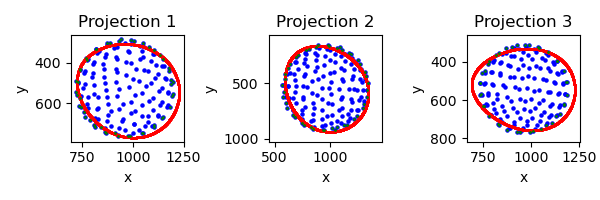

   0 Loss: 12171.234130859375 Volume: 4.249396 SSE: 0.0 Chamfer: 0.0
   1 Loss: 11423.84521484375 Volume: 4.249418 SSE: 0.000647057197407305 Chamfer: 7.988360266608652e-06
   2 Loss: 10258.916015625 Volume: 4.249486 SSE: 0.003907925563381229 Chamfer: 4.824599454877898e-05
   3 Loss: 9409.766235351562 Volume: 4.249496 SSE: 0.01055397150487143 Chamfer: 0.0001302959572058171
   4 Loss: 8470.732421875 Volume: 4.249396 SSE: 0.02045742105155603 Chamfer: 0.000252560741500929
   5 Loss: 7790.20263671875 Volume: 4.249396 SSE: 0.032896993578538536 Chamfer: 0.0004061356885358691
   6 Loss: 7160.6378173828125 Volume: 4.249396 SSE: 0.047226758580706234 Chamfer: 0.0005830465233884752
   7 Loss: 6660.5340576171875 Volume: 4.249396 SSE: 0.06270399517619173 Chamfer: 0.0007741230656392872
   8 Loss: 6137.2259521484375 Volume: 4.249396 SSE: 0.07894468569968817 Chamfer: 0.0009746254654601216
   9 Loss: 5800.03173828125 Volume: 4.249396 SSE: 0.0955178295393748 Chamfer: 0.0011792323784902692


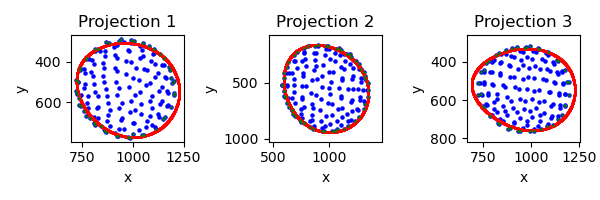

  10 Loss: 5406.7840576171875 Volume: 4.249396 SSE: 0.11227456390378676 Chamfer: 0.0013861054321750998
  11 Loss: 5118.9892578125 Volume: 4.249396 SSE: 0.12906389850529518 Chamfer: 0.0015933815157040954
  12 Loss: 5043.048400878906 Volume: 4.249396 SSE: 0.1457976341508491 Chamfer: 0.0017999706324189901
  13 Loss: 4788.421936035156 Volume: 4.249396 SSE: 0.16238012619416947 Chamfer: 0.00200469302944839
  14 Loss: 4886.087341308594 Volume: 4.249396 SSE: 0.17873845370298436 Chamfer: 0.002206647302955389
  15 Loss: 4683.921813964844 Volume: 4.249396 SSE: 0.19485803501791146 Chamfer: 0.002405654639005661
  16 Loss: 4510.15380859375 Volume: 4.249396 SSE: 0.21068649645575097 Chamfer: 0.002601067768409848
  17 Loss: 4350.83251953125 Volume: 4.249396 SSE: 0.22623946636581027 Chamfer: 0.002793080173432827
  18 Loss: 4203.975524902344 Volume: 4.249396 SSE: 0.24153838875889427 Chamfer: 0.00298195518553257
  19 Loss: 4068.2821655273438 Volume: 4.249396 SSE: 0.25659455970476974 Chamfer: 0.00316783413

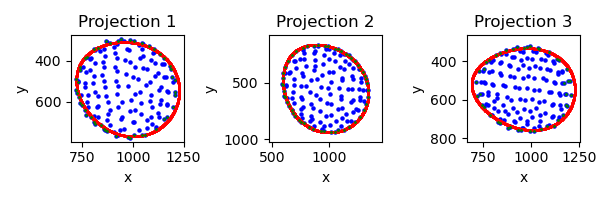

  20 Loss: 3890.6982421875 Volume: 4.249396 SSE: 0.27140730188475726 Chamfer: 0.003350707469508052
  21 Loss: 3775.1431274414062 Volume: 4.249396 SSE: 0.28592535888962617 Chamfer: 0.0035299425944685936
  22 Loss: 3652.3422241210938 Volume: 4.249396 SSE: 0.3001592601090633 Chamfer: 0.0037056701257824898
  23 Loss: 3606.4608764648438 Volume: 4.249396 SSE: 0.3140728750626203 Chamfer: 0.003877443028613925
  24 Loss: 3514.2544555664062 Volume: 4.249396 SSE: 0.32774114916445224 Chamfer: 0.004046186804771423
  25 Loss: 3421.5625 Volume: 4.249396 SSE: 0.34115857546660255 Chamfer: 0.004211834631860256
  26 Loss: 3341.4535522460938 Volume: 4.249396 SSE: 0.35428780968706003 Chamfer: 0.004373923409730196
  27 Loss: 3266.6183471679688 Volume: 4.249396 SSE: 0.36713573706627395 Chamfer: 0.004532540217041969
  28 Loss: 3182.3602294921875 Volume: 4.249396 SSE: 0.3797140804896942 Chamfer: 0.004687828477472067
  29 Loss: 3116.6091918945312 Volume: 4.249396 SSE: 0.39202832003606797 Chamfer: 0.004839855711

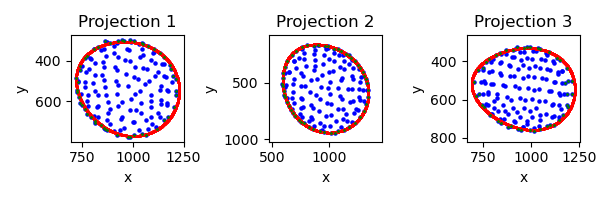

  30 Loss: 3054.6490478515625 Volume: 4.249396 SSE: 0.40409542424554046 Chamfer: 0.004988832399249077
  31 Loss: 2995.7666015625 Volume: 4.249396 SSE: 0.4159477835696354 Chamfer: 0.00513515854254365
  32 Loss: 2940.711669921875 Volume: 4.249396 SSE: 0.4275304617841255 Chamfer: 0.005278154741972685
  33 Loss: 2888.65478515625 Volume: 4.249396 SSE: 0.4388750096000468 Chamfer: 0.005418210756033659
  34 Loss: 2839.2941284179688 Volume: 4.249396 SSE: 0.4499853215563937 Chamfer: 0.005555374547839165
  35 Loss: 2935.2957153320312 Volume: 4.249396 SSE: 0.4608854475326727 Chamfer: 0.005689944140613079
  36 Loss: 2891.1251831054688 Volume: 4.249396 SSE: 0.47152071511701554 Chamfer: 0.005821243394166231
  37 Loss: 2845.8145141601562 Volume: 4.249396 SSE: 0.48198871974798874 Chamfer: 0.005950477905571461
  38 Loss: 2801.6036987304688 Volume: 4.249396 SSE: 0.49222519871084996 Chamfer: 0.006076853722333908
  39 Loss: 2760.1376342773438 Volume: 4.249396 SSE: 0.5023418909773504 Chamfer: 0.006201751530

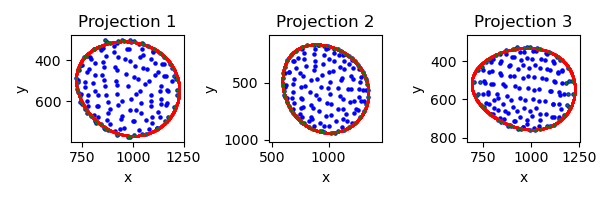

  40 Loss: 2720.4165649414062 Volume: 4.249396 SSE: 0.5123140415419297 Chamfer: 0.006324865389615297
  41 Loss: 2682.5979614257812 Volume: 4.249396 SSE: 0.5221064173738726 Chamfer: 0.006445758044719696
  42 Loss: 2643.486328125 Volume: 4.249396 SSE: 0.5317287252483187 Chamfer: 0.006564552430063486
  43 Loss: 2592.9434204101562 Volume: 4.249396 SSE: 0.541196929811786 Chamfer: 0.006681443192064762
  44 Loss: 2559.7998046875 Volume: 4.249396 SSE: 0.5504815274725229 Chamfer: 0.006796068511903286
  45 Loss: 2528.159637451172 Volume: 4.249396 SSE: 0.5595869872250284 Chamfer: 0.006908481474965811
  46 Loss: 2500.8966064453125 Volume: 4.249396 SSE: 0.5685040498753582 Chamfer: 0.007018568925559521
  47 Loss: 2469.1131591796875 Volume: 4.249396 SSE: 0.5772942812033175 Chamfer: 0.007127089891582727
  48 Loss: 2557.4559020996094 Volume: 4.249396 SSE: 0.5859031679884468 Chamfer: 0.007233372423797846
  49 Loss: 2530.113067626953 Volume: 4.249396 SSE: 0.594275183843215 Chamfer: 0.007336731534451246


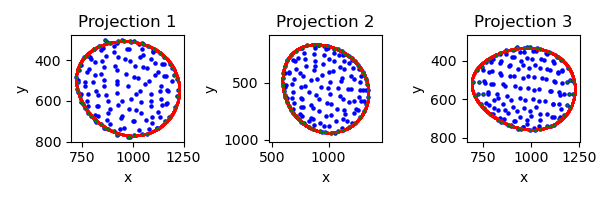

  50 Loss: 2811.7138671875 Volume: 4.249396 SSE: 0.602455786977168 Chamfer: 0.007437725085765123
  51 Loss: 2784.4320678710938 Volume: 4.249396 SSE: 0.6104249333851745 Chamfer: 0.00753611046820879
  52 Loss: 2749.1537475585938 Volume: 4.249396 SSE: 0.6182699928167352 Chamfer: 0.007632962893694639
  53 Loss: 2717.001953125 Volume: 4.249396 SSE: 0.6259813358583116 Chamfer: 0.007728165481239557
  54 Loss: 2685.2328491210938 Volume: 4.249396 SSE: 0.6336054325145181 Chamfer: 0.007822290062904358
  55 Loss: 2657.7828979492188 Volume: 4.249396 SSE: 0.6411493621344684 Chamfer: 0.00791542511433363
  56 Loss: 2624.5394897460938 Volume: 4.249396 SSE: 0.6486128510420415 Chamfer: 0.008007566444575787
  57 Loss: 2595.5850219726562 Volume: 4.249396 SSE: 0.6559746979581205 Chamfer: 0.008098453283309937
  58 Loss: 2485.3553771972656 Volume: 4.249396 SSE: 0.6632517616759254 Chamfer: 0.008188293315470219
  59 Loss: 2460.147247314453 Volume: 4.249396 SSE: 0.6704584379812151 Chamfer: 0.00827726535499096


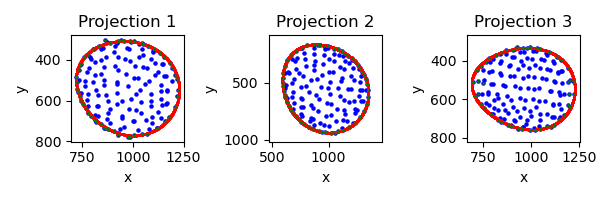

  60 Loss: 2435.0144958496094 Volume: 4.249396 SSE: 0.6775688692083559 Chamfer: 0.008365047164261341
  61 Loss: 2411.242218017578 Volume: 4.249396 SSE: 0.6845764475004191 Chamfer: 0.008451560512185097
  62 Loss: 2388.11767578125 Volume: 4.249396 SSE: 0.6915040052358794 Chamfer: 0.00853708665817976
  63 Loss: 2365.652618408203 Volume: 4.249396 SSE: 0.6983559482754024 Chamfer: 0.00862167775630951
  64 Loss: 2347.375030517578 Volume: 4.249396 SSE: 0.7051192760790874 Chamfer: 0.008705176413059235
  65 Loss: 2322.2740173339844 Volume: 4.249396 SSE: 0.7118273840561946 Chamfer: 0.008787991479039192
  66 Loss: 2297.620849609375 Volume: 4.249396 SSE: 0.7185653501745035 Chamfer: 0.008871178142726421
  67 Loss: 2276.468963623047 Volume: 4.249396 SSE: 0.7252633545017316 Chamfer: 0.008953867480158806
  68 Loss: 2259.244842529297 Volume: 4.249396 SSE: 0.7318957010580586 Chamfer: 0.009035748429596424
  69 Loss: 2239.145050048828 Volume: 4.249396 SSE: 0.7384853852270423 Chamfer: 0.009117103181779385


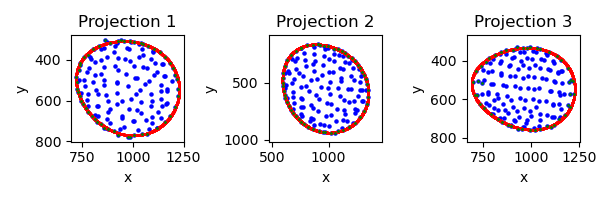

  70 Loss: 2215.386505126953 Volume: 4.249396 SSE: 0.7450119335358492 Chamfer: 0.009197678416967392
  71 Loss: 2143.265838623047 Volume: 4.249396 SSE: 0.751487812843901 Chamfer: 0.009277628734707832
  72 Loss: 2125.504150390625 Volume: 4.249396 SSE: 0.7577912820832513 Chamfer: 0.009355448186397552
  73 Loss: 2108.1077575683594 Volume: 4.249396 SSE: 0.7639669548910696 Chamfer: 0.009431690908968449
  74 Loss: 2087.436981201172 Volume: 4.249396 SSE: 0.7700434694878144 Chamfer: 0.009506708942353725
  75 Loss: 2071.0328674316406 Volume: 4.249396 SSE: 0.7760175959125537 Chamfer: 0.009580465033650398
  76 Loss: 2051.3356018066406 Volume: 4.249396 SSE: 0.7818850119462684 Chamfer: 0.009652901440858841
  77 Loss: 2040.1318359375 Volume: 4.249396 SSE: 0.7876380687863054 Chamfer: 0.009723927825689316
  78 Loss: 2021.5065002441406 Volume: 4.249396 SSE: 0.7933118763901129 Chamfer: 0.009793974459171295
  79 Loss: 2010.9263610839844 Volume: 4.249396 SSE: 0.7989001494871092 Chamfer: 0.00986296497285366

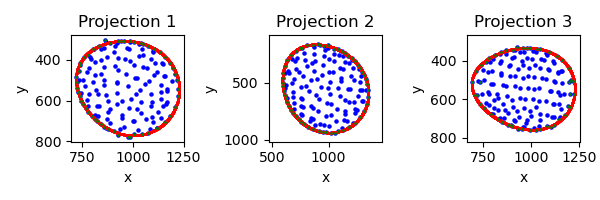

  80 Loss: 1993.0548095703125 Volume: 4.249396 SSE: 0.8044285225437487 Chamfer: 0.009931215085089207
  81 Loss: 1983.2490539550781 Volume: 4.249396 SSE: 0.8098787195649718 Chamfer: 0.0099985022097826
  82 Loss: 1966.201171875 Volume: 4.249396 SSE: 0.8152942328582748 Chamfer: 0.010065360926091671
  83 Loss: 1957.1246337890625 Volume: 4.249396 SSE: 0.8206488735040632 Chamfer: 0.010131468065083027
  84 Loss: 1940.8003234863281 Volume: 4.249396 SSE: 0.8259427083970097 Chamfer: 0.010196823626756668
  85 Loss: 1932.26806640625 Volume: 4.249396 SSE: 0.8311744986416296 Chamfer: 0.01026141457259655
  86 Loss: 1916.5470886230469 Volume: 4.249396 SSE: 0.836338662019667 Chamfer: 0.010325168259441853
  87 Loss: 1908.7199401855469 Volume: 4.249396 SSE: 0.8414176134240161 Chamfer: 0.010387871414422989
  88 Loss: 1893.748779296875 Volume: 4.249396 SSE: 0.8464448015802869 Chamfer: 0.010449935682117939
  89 Loss: 2095.351104736328 Volume: 4.249396 SSE: 0.8513898979534281 Chamfer: 0.010510986670851707


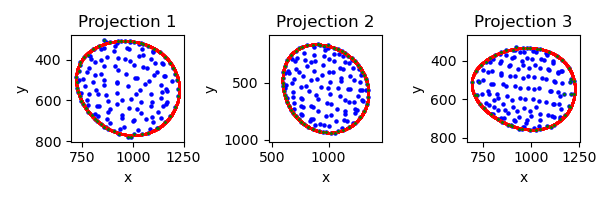

  90 Loss: 2078.538055419922 Volume: 4.249396 SSE: 0.8561815355383143 Chamfer: 0.010570142418146133
  91 Loss: 1836.3825988769531 Volume: 4.249396 SSE: 0.8608755111181124 Chamfer: 0.010628092102706432
  92 Loss: 1803.2389831542969 Volume: 4.249396 SSE: 0.8654167122584255 Chamfer: 0.01068415679037571
  93 Loss: 1798.2283020019531 Volume: 4.249396 SSE: 0.8696853887852632 Chamfer: 0.010736856609582901
  94 Loss: 1786.2217712402344 Volume: 4.249396 SSE: 0.8738074936987857 Chamfer: 0.010787746869027615
  95 Loss: 1778.0718994140625 Volume: 4.249396 SSE: 0.8778042899275789 Chamfer: 0.010837090201675892
  96 Loss: 1773.8468933105469 Volume: 4.249396 SSE: 0.8817135790970607 Chamfer: 0.01088535226881504
  97 Loss: 1762.4891662597656 Volume: 4.249396 SSE: 0.8855723670212726 Chamfer: 0.010932990349829197
  98 Loss: 1754.9482727050781 Volume: 4.249396 SSE: 0.8893681755691322 Chamfer: 0.010979853570461273
  99 Loss: 1751.2882995605469 Volume: 4.249396 SSE: 0.89313147697198 Chamfer: 0.01102631445974

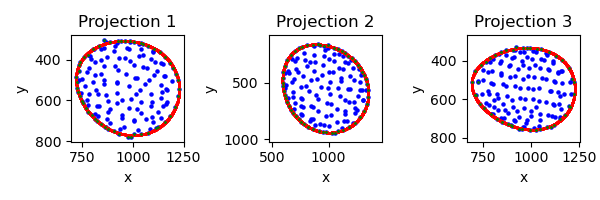

 100 Loss: 1847.4565124511719 Volume: 4.249396 SSE: 0.8968975320917083 Chamfer: 0.011072808876633644
 101 Loss: 1838.8478088378906 Volume: 4.249396 SSE: 0.9005941635620665 Chamfer: 0.011118446476757526
 102 Loss: 1833.680419921875 Volume: 4.249396 SSE: 0.9042464240596233 Chamfer: 0.01116353552788496
 103 Loss: 2183.682098388672 Volume: 4.249396 SSE: 0.9078761330943854 Chamfer: 0.011208347976207733
 104 Loss: 2165.8251953125 Volume: 4.249396 SSE: 0.9113741949335331 Chamfer: 0.011251532472670078
 105 Loss: 2149.954071044922 Volume: 4.249396 SSE: 0.9148011493766688 Chamfer: 0.01129384059458971
 106 Loss: 2133.502655029297 Volume: 4.249396 SSE: 0.9182002104710291 Chamfer: 0.011335805989801884
 107 Loss: 2121.461639404297 Volume: 4.249396 SSE: 0.9216324159879448 Chamfer: 0.011378178372979164
 108 Loss: 2105.851593017578 Volume: 4.249396 SSE: 0.925088051332173 Chamfer: 0.01142084039747715
 109 Loss: 2086.8495178222656 Volume: 4.249396 SSE: 0.9285805471499062 Chamfer: 0.011463955976068974


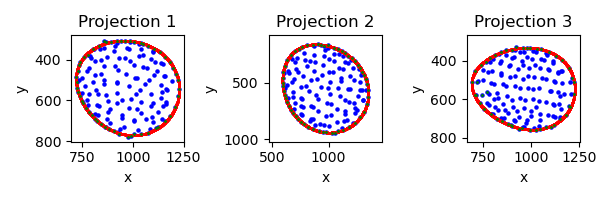

 110 Loss: 2072.5 Volume: 4.249396 SSE: 0.9321058913197774 Chamfer: 0.011507481336593628
 111 Loss: 2058.759765625 Volume: 4.249396 SSE: 0.9356467303475666 Chamfer: 0.01155119389295578
 112 Loss: 2049.936981201172 Volume: 4.249396 SSE: 0.9391772488030633 Chamfer: 0.011594779789447784
 113 Loss: 2260.0889587402344 Volume: 4.249396 SSE: 0.9427029712824059 Chamfer: 0.011638307943940163
 114 Loss: 2249.691162109375 Volume: 4.249396 SSE: 0.9463318366378582 Chamfer: 0.011683110147714615
 115 Loss: 2229.9977111816406 Volume: 4.249396 SSE: 0.9500353499174794 Chamfer: 0.011728830635547638
 116 Loss: 2218.859405517578 Volume: 4.249396 SSE: 0.9537536005346181 Chamfer: 0.01177473459392786
 117 Loss: 2203.88427734375 Volume: 4.249396 SSE: 0.9574937574726583 Chamfer: 0.01182091049849987
 118 Loss: 2204.376220703125 Volume: 4.249396 SSE: 0.9612464947827183 Chamfer: 0.011867239139974117
 119 Loss: 2172.7435302734375 Volume: 4.249396 SSE: 0.9648903870552484 Chamfer: 0.011912227608263493


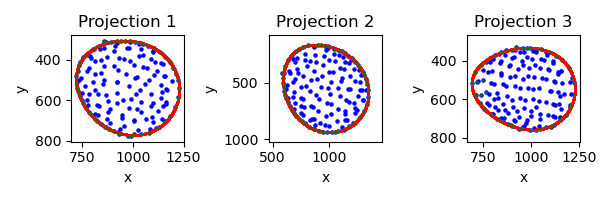

 120 Loss: 1595.8781433105469 Volume: 4.249396 SSE: 0.9685481859336186 Chamfer: 0.011957384645938873
 121 Loss: 1591.3316345214844 Volume: 4.249396 SSE: 0.9715677328538457 Chamfer: 0.011994662694633007
 122 Loss: 1585.4811096191406 Volume: 4.249396 SSE: 0.9742407271453937 Chamfer: 0.012027661316096783
 123 Loss: 1579.2442321777344 Volume: 4.249396 SSE: 0.9767230304654385 Chamfer: 0.012058308348059654
 124 Loss: 1573.0702209472656 Volume: 4.249396 SSE: 0.9791116548974412 Chamfer: 0.012087798677384853
 125 Loss: 1567.0751953125 Volume: 4.249396 SSE: 0.9814826089137576 Chamfer: 0.012117069214582443
 126 Loss: 1561.3951110839844 Volume: 4.249396 SSE: 0.9838285380836919 Chamfer: 0.012146029621362686
 127 Loss: 1556.0884094238281 Volume: 4.249396 SSE: 0.9861523275820361 Chamfer: 0.012174718081951141
 128 Loss: 1555.9751892089844 Volume: 4.249396 SSE: 0.9884415701263948 Chamfer: 0.012202983722090721
 129 Loss: 1546.5879821777344 Volume: 4.249396 SSE: 0.9906971068914228 Chamfer: 0.012230829335

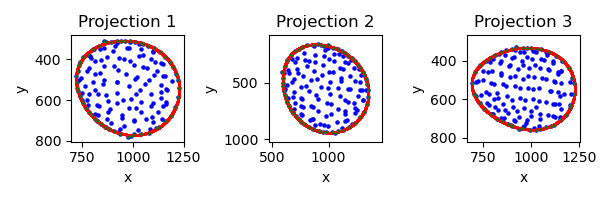

 130 Loss: 1542.2904968261719 Volume: 4.249396 SSE: 0.9929107470077777 Chamfer: 0.012258157134056091
 131 Loss: 1538.2061767578125 Volume: 4.249396 SSE: 0.9950846924808262 Chamfer: 0.012284995056688786
 132 Loss: 1539.1294860839844 Volume: 4.249396 SSE: 0.997256778672183 Chamfer: 0.012311811558902264
 133 Loss: 1530.4360961914062 Volume: 4.249396 SSE: 0.9994201423330994 Chamfer: 0.012338520959019661
 134 Loss: 1526.7262268066406 Volume: 4.249396 SSE: 1.0015643751028414 Chamfer: 0.012364991940557957
 135 Loss: 1523.1634521484375 Volume: 4.249396 SSE: 1.0036750803375865 Chamfer: 0.012391050346195698
 136 Loss: 1524.7288513183594 Volume: 4.249396 SSE: 1.0057524190010416 Chamfer: 0.012416697107255459
 137 Loss: 1516.5231323242188 Volume: 4.249396 SSE: 1.0078090252791034 Chamfer: 0.012442086823284626
 138 Loss: 1513.3853149414062 Volume: 4.249396 SSE: 1.0098459046468107 Chamfer: 0.012467232532799244
 139 Loss: 1510.3715515136719 Volume: 4.249396 SSE: 1.011848142162596 Chamfer: 0.01249195169

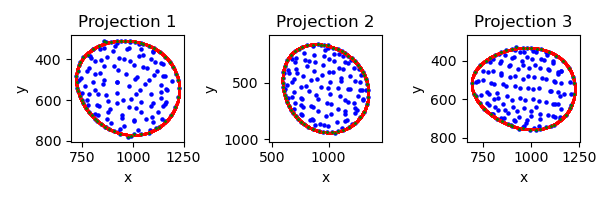

 140 Loss: 1507.4894714355469 Volume: 4.249396 SSE: 1.0138183095120772 Chamfer: 0.01251627504825592
 141 Loss: 1509.8637390136719 Volume: 4.249396 SSE: 1.0157477788376847 Chamfer: 0.012540094554424286
 142 Loss: 1502.1292114257812 Volume: 4.249396 SSE: 1.0176562561107991 Chamfer: 0.012563657015562057
 143 Loss: 1499.6116638183594 Volume: 4.249396 SSE: 1.0195509735174786 Chamfer: 0.012587049975991249
 144 Loss: 1497.215576171875 Volume: 4.249396 SSE: 1.0214134806982766 Chamfer: 0.012610044330358505
 145 Loss: 1494.8561096191406 Volume: 4.249396 SSE: 1.0232325867299068 Chamfer: 0.012632501311600208
 146 Loss: 1497.7471923828125 Volume: 4.249396 SSE: 1.025019103968146 Chamfer: 0.012654557824134827
 147 Loss: 1490.2030944824219 Volume: 4.249396 SSE: 1.0267773835062926 Chamfer: 0.01267626415938139
 148 Loss: 1473.8511657714844 Volume: 4.249396 SSE: 1.0285017018376605 Chamfer: 0.012697551399469376
 149 Loss: 1470.6697082519531 Volume: 4.249396 SSE: 1.0303534512639179 Chamfer: 0.0127204125747

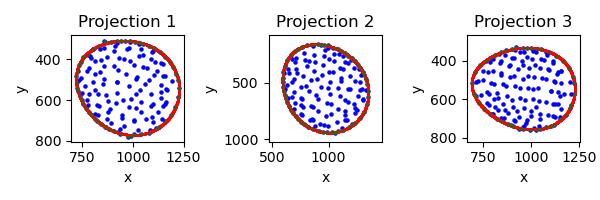

 150 Loss: 1472.4928283691406 Volume: 4.249396 SSE: 1.0322619834877638 Chamfer: 0.012743975035846233
 151 Loss: 1463.7191772460938 Volume: 4.249396 SSE: 1.0341928552677377 Chamfer: 0.012767812237143517
 152 Loss: 1460.3639221191406 Volume: 4.249396 SSE: 1.0361037123811818 Chamfer: 0.012791403569281101
 153 Loss: 1462.3406982421875 Volume: 4.249396 SSE: 1.0379781716445278 Chamfer: 0.012814545072615147
 154 Loss: 1453.8278198242188 Volume: 4.249396 SSE: 1.0398587144664022 Chamfer: 0.012837762013077736
 155 Loss: 1450.7408142089844 Volume: 4.249396 SSE: 1.041716225579844 Chamfer: 0.012860693968832493
 156 Loss: 1447.8096008300781 Volume: 4.249396 SSE: 1.043524024803495 Chamfer: 0.012883013114333153
 157 Loss: 1450.3886413574219 Volume: 4.249396 SSE: 1.045284166127853 Chamfer: 0.012904740869998932
 158 Loss: 1442.4462890625 Volume: 4.249396 SSE: 1.0469903925418933 Chamfer: 0.012925807386636734
 159 Loss: 1439.9635314941406 Volume: 4.249396 SSE: 1.048641562626445 Chamfer: 0.0129461940377950

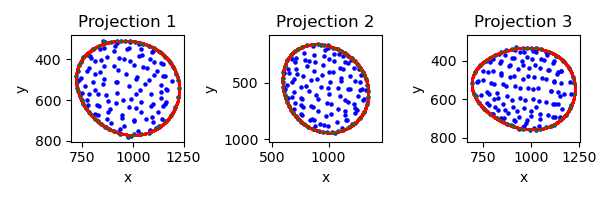

 160 Loss: 1442.9121398925781 Volume: 4.249396 SSE: 1.0502577042256422 Chamfer: 0.012966143898665905
 161 Loss: 1435.2546691894531 Volume: 4.249396 SSE: 1.0518685804045802 Chamfer: 0.012986031360924244
 162 Loss: 1432.9560852050781 Volume: 4.249396 SSE: 1.053461196362175 Chamfer: 0.013005692511796951
 163 Loss: 1430.6889343261719 Volume: 4.249396 SSE: 1.0550223584114702 Chamfer: 0.013024967163801193
 164 Loss: 1433.8778686523438 Volume: 4.249396 SSE: 1.0565510922940853 Chamfer: 0.013043840415775776
 165 Loss: 1431.6986083984375 Volume: 4.249396 SSE: 1.0580629573186184 Chamfer: 0.013062505051493645
 166 Loss: 1424.3963623046875 Volume: 4.249396 SSE: 1.05954275252651 Chamfer: 0.013080774806439877
 167 Loss: 1422.3976135253906 Volume: 4.249396 SSE: 1.06099702464466 Chamfer: 0.013098728843033314
 168 Loss: 1420.3996276855469 Volume: 4.249396 SSE: 1.0624384438083798 Chamfer: 0.013116526417434216
 169 Loss: 1418.4185791015625 Volume: 4.249396 SSE: 1.0638595709830403 Chamfer: 0.01313406880944

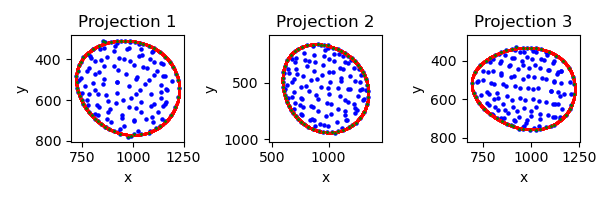

 170 Loss: 1421.9058227539062 Volume: 4.249396 SSE: 1.06524081588494 Chamfer: 0.013151121325790882
 171 Loss: 1420.01953125 Volume: 4.249396 SSE: 1.0666029356584006 Chamfer: 0.01316793728619814
 172 Loss: 1412.9693603515625 Volume: 4.249396 SSE: 1.0679426346252863 Chamfer: 0.013184476643800735
 173 Loss: 1411.23291015625 Volume: 4.249396 SSE: 1.0692537873472412 Chamfer: 0.013200663961470127
 174 Loss: 1409.542236328125 Volume: 4.249396 SSE: 1.0705400602921855 Chamfer: 0.013216543011367321
 175 Loss: 1413.2588195800781 Volume: 4.249396 SSE: 1.071796754447389 Chamfer: 0.013232058845460415
 176 Loss: 1411.7181396484375 Volume: 4.249396 SSE: 1.0730310903774944 Chamfer: 0.013247297145426273
 177 Loss: 1405.0692749023438 Volume: 4.249396 SSE: 1.0742386003457263 Chamfer: 0.013262205757200718
 178 Loss: 1403.6033630371094 Volume: 4.249396 SSE: 1.0754288671915253 Chamfer: 0.013276901096105576
 179 Loss: 1402.1385192871094 Volume: 4.249396 SSE: 1.0766049358587677 Chamfer: 0.013291419483721256


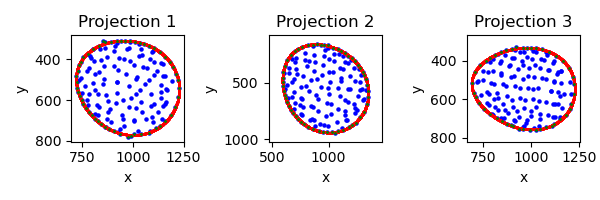

 180 Loss: 1405.9980773925781 Volume: 4.249396 SSE: 1.0777616602541977 Chamfer: 0.013305697590112686
 181 Loss: 1399.4291687011719 Volume: 4.249396 SSE: 1.078901678997981 Chamfer: 0.013319774530827999
 182 Loss: 1398.138427734375 Volume: 4.249396 SSE: 1.0800320837304367 Chamfer: 0.013333729468286037
 183 Loss: 1402.1687316894531 Volume: 4.249396 SSE: 1.0811612355333338 Chamfer: 0.013347668573260307
 184 Loss: 1395.5728149414062 Volume: 4.249396 SSE: 1.0822911703506672 Chamfer: 0.013361618854105473
 185 Loss: 1394.2539978027344 Volume: 4.249396 SSE: 1.083414957235329 Chamfer: 0.013375494629144669
 186 Loss: 1398.2579040527344 Volume: 4.249396 SSE: 1.0845317445607736 Chamfer: 0.01338928285986185
 187 Loss: 1400.1797485351562 Volume: 4.249396 SSE: 1.085642565625727 Chamfer: 0.013402994722127914
 188 Loss: 1398.5020446777344 Volume: 4.249396 SSE: 1.0867147207334307 Chamfer: 0.013416231609880924
 189 Loss: 1396.7527770996094 Volume: 4.249396 SSE: 1.087767131608825 Chamfer: 0.013429226353764

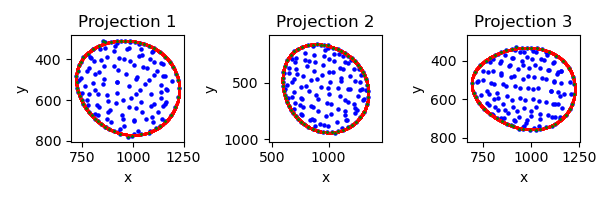

 190 Loss: 1400.4727172851562 Volume: 4.249396 SSE: 1.0887983101225214 Chamfer: 0.013441953808069229
 191 Loss: 1393.3842468261719 Volume: 4.249396 SSE: 1.0898377579139964 Chamfer: 0.01345478743314743
 192 Loss: 1391.7680358886719 Volume: 4.249396 SSE: 1.090887297101389 Chamfer: 0.013467744924128056
 193 Loss: 1390.1841735839844 Volume: 4.249396 SSE: 1.0919411468789504 Chamfer: 0.013480756431818008
 194 Loss: 1388.6056518554688 Volume: 4.249396 SSE: 1.0929916621171794 Chamfer: 0.013493725098669529
 195 Loss: 1387.0252990722656 Volume: 4.249396 SSE: 1.0940232417585987 Chamfer: 0.013506460934877396
 196 Loss: 1391.2620544433594 Volume: 4.249396 SSE: 1.0950426663377646 Chamfer: 0.013519044034183025
 197 Loss: 1384.0538024902344 Volume: 4.249396 SSE: 1.0960535981673318 Chamfer: 0.013531524688005447
 198 Loss: 1382.6312255859375 Volume: 4.249396 SSE: 1.0970511217775958 Chamfer: 0.013543841429054737
 199 Loss: 1381.2255859375 Volume: 4.249396 SSE: 1.0980326212417326 Chamfer: 0.01355595793575

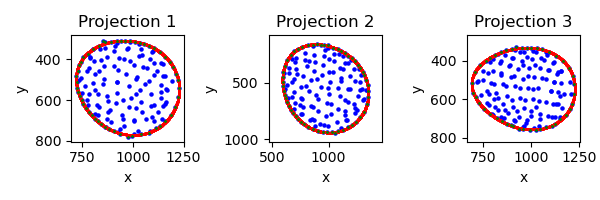

AttributeError: 'Canvas' object has no attribute 'key_press_event'

In [92]:
view_idx = [0,2,3]
tgt = "balloon"
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])
final_verts, history = outer_problem(sphere, parabola, projmats, batch_tgt_edgemap_info, n_iters=200, lr=1e-6,moment=0.5)

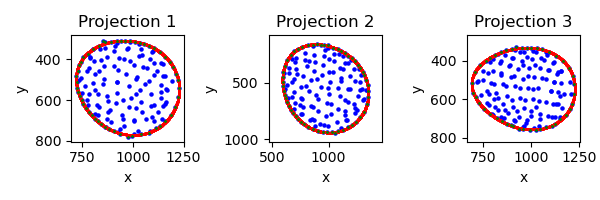

In [93]:
plot_projections(final_verts.detach().squeeze().double(), projmats, tgt_edgemap_info)

In [94]:
def plot_vertices(verts):
    x, y, z = verts.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_aspect("equal")
    ax.view_init(190, 30)
    plt.show()

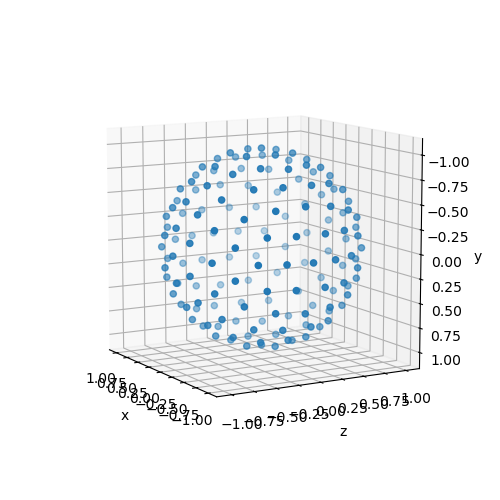

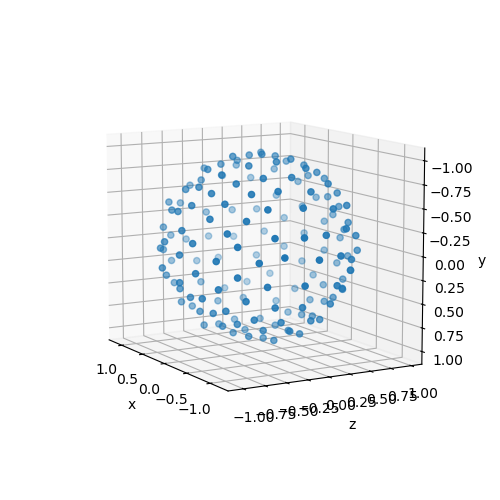

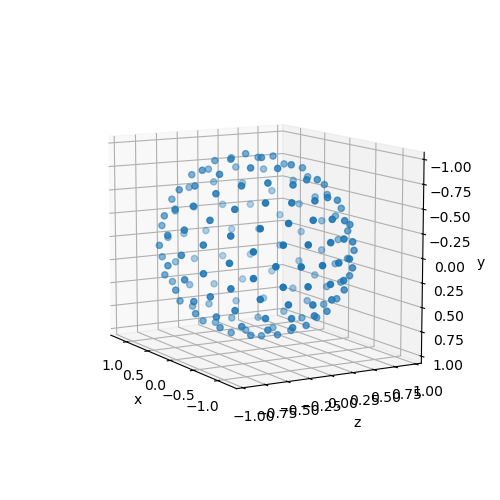

In [95]:
plot_vertices(sphere.verts_packed())
plot_vertices(final_verts)
plot_vertices(balloon.verts_packed())

## Sky background

In [99]:
renders_path = "../data/sky/renders"
renders = load_renders(renders_path)
edgemaps, edgemaps_len = get_edgemaps(renders,t1=10,t2=200)
matrices_path = "../data/sky/cameras"
matrices = load_camera_matrices(matrices_path)

In [113]:
# view_idx = [2,3,4,7,8,9,11]
# view_idx = [4,7,8,9,11]
view_idx = [1,2,4,5,6,7]
tgt = "balloon"
projmats, tgt_edgemap_info = get_projmats_and_edgemap_info(view_idx, tgt, matrices, edgemaps, edgemaps_len)
batch_tgt_edgemap_info = ([tgt_edgemap_info[0]],[tgt_edgemap_info[1]])

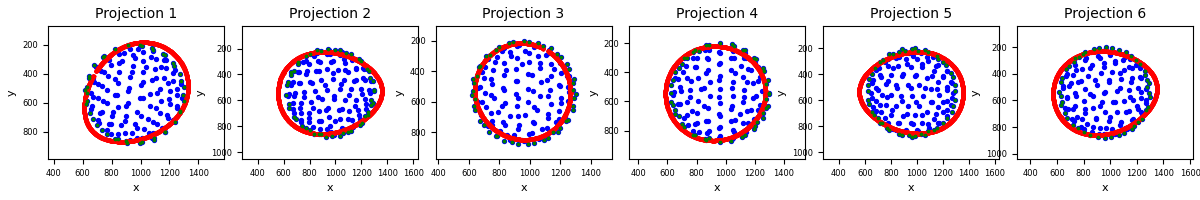

   0 Loss: 21438.23974609375 Volume: 4.249396 SSE: 0.0 Chamfer: 0.0
   1 Loss: 20181.009521484375 Volume: 4.249451 SSE: 0.001191978143843717 Chamfer: 1.471577888878528e-05
   2 Loss: 18523.656005859375 Volume: 4.249396 SSE: 0.007218767577364835 Chamfer: 8.912060729926452e-05
   3 Loss: 16782.867431640625 Volume: 4.249396 SSE: 0.019995712171413115 Chamfer: 0.0002468606398906559
   4 Loss: 15063.504638671875 Volume: 4.249396 SSE: 0.03945764436936992 Chamfer: 0.000487131328554824
   5 Loss: 13548.299560546875 Volume: 4.249396 SSE: 0.06453184675168781 Chamfer: 0.0007966896519064903
   6 Loss: 12364.825439453125 Volume: 4.249396 SSE: 0.0938672851797835 Chamfer: 0.001158855389803648
   7 Loss: 11206.102294921875 Volume: 4.249396 SSE: 0.12634592686327129 Chamfer: 0.0015598263125866652
   8 Loss: 10266.29150390625 Volume: 4.249396 SSE: 0.16082034433617742 Chamfer: 0.0019854360725730658
   9 Loss: 9468.77685546875 Volume: 4.249396 SSE: 0.19642501229329543 Chamfer: 0.0024250000715255737


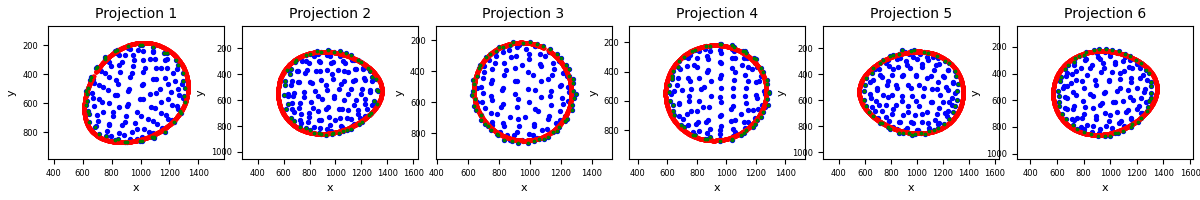

  10 Loss: 8725.107421875 Volume: 4.249397 SSE: 0.23251891568670283 Chamfer: 0.0028706032317131758
  11 Loss: 8132.2662353515625 Volume: 4.249397 SSE: 0.26863180209699566 Chamfer: 0.003316442249342799
  12 Loss: 7596.6522216796875 Volume: 4.249397 SSE: 0.30451569597849565 Chamfer: 0.003759453073143959
  13 Loss: 7117.48291015625 Volume: 4.249397 SSE: 0.339819343962715 Chamfer: 0.004195300862193108
  14 Loss: 6704.7027587890625 Volume: 4.249397 SSE: 0.3742915694902686 Chamfer: 0.004620883613824844
  15 Loss: 6321.3751220703125 Volume: 4.249397 SSE: 0.40768720634348543 Chamfer: 0.005033174995332956
  16 Loss: 5965.8355712890625 Volume: 4.249397 SSE: 0.4398958940837953 Chamfer: 0.005430813413113356
  17 Loss: 5691.7095947265625 Volume: 4.249397 SSE: 0.4709642776421125 Chamfer: 0.00581437349319458
  18 Loss: 5460.2972412109375 Volume: 4.249397 SSE: 0.500852520191563 Chamfer: 0.006183364428579807
  19 Loss: 5244.5172119140625 Volume: 4.249397 SSE: 0.5295730047024976 Chamfer: 0.0065379380248

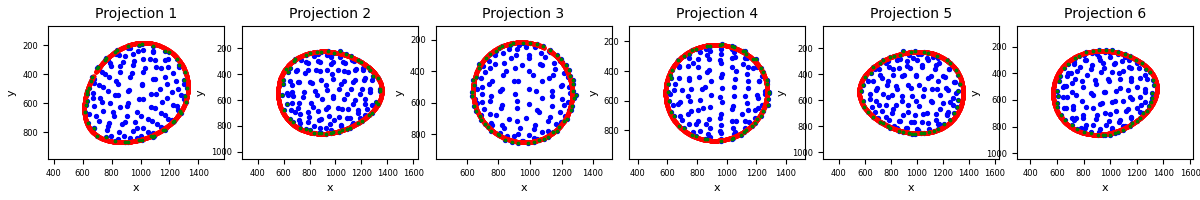

  20 Loss: 5041.65283203125 Volume: 4.249397 SSE: 0.5571349874263937 Chamfer: 0.006878211162984371
  21 Loss: 4875.2880859375 Volume: 4.249397 SSE: 0.5835564228081517 Chamfer: 0.00720440037548542
  22 Loss: 4728.12255859375 Volume: 4.249397 SSE: 0.6090265388487699 Chamfer: 0.007518845610320568
  23 Loss: 4577.5634765625 Volume: 4.249397 SSE: 0.6337134920721621 Chamfer: 0.007823623716831207
  24 Loss: 4442.344665527344 Volume: 4.249397 SSE: 0.6575391974385169 Chamfer: 0.008117768913507462
  25 Loss: 4332.449035644531 Volume: 4.249397 SSE: 0.6804775292308407 Chamfer: 0.008400957100093365
  26 Loss: 4214.69970703125 Volume: 4.249397 SSE: 0.7025715260842575 Chamfer: 0.008673721924424171
  27 Loss: 4106.372985839844 Volume: 4.249397 SSE: 0.7238008220109057 Chamfer: 0.00893581286072731
  28 Loss: 4007.3095703125 Volume: 4.249397 SSE: 0.744187776490896 Chamfer: 0.009187503717839718
  29 Loss: 3917.0327758789062 Volume: 4.249397 SSE: 0.7637337577180414 Chamfer: 0.009428812190890312


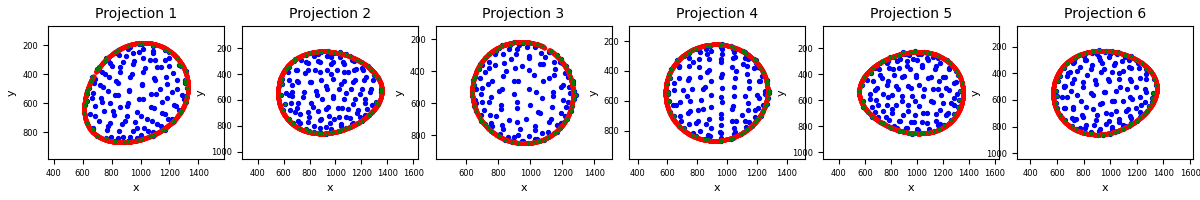

  30 Loss: 4644.784851074219 Volume: 4.249397 SSE: 0.7824759840813055 Chamfer: 0.009660197421908379
  31 Loss: 7968.4173583984375 Volume: 4.249397 SSE: 0.8007311631394657 Chamfer: 0.009885570034384727
  32 Loss: 3676.2612915039062 Volume: 4.249397 SSE: 0.8178837212780521 Chamfer: 0.010097329504787922
  33 Loss: 3612.6480102539062 Volume: 4.249397 SSE: 0.834445339452671 Chamfer: 0.010301794856786728
  34 Loss: 3553.399658203125 Volume: 4.249397 SSE: 0.8503896800271248 Chamfer: 0.01049863826483488
  35 Loss: 3498.3639526367188 Volume: 4.249397 SSE: 0.8657336303172178 Chamfer: 0.01068806927651167
  36 Loss: 3447.1231079101562 Volume: 4.249397 SSE: 0.8805052265034241 Chamfer: 0.010870435275137424
  37 Loss: 3399.2788696289062 Volume: 4.249397 SSE: 0.8947517740888626 Chamfer: 0.011046318337321281
  38 Loss: 3354.6328735351562 Volume: 4.249397 SSE: 0.908502070838972 Chamfer: 0.011216074228286743
  39 Loss: 3308.5943603515625 Volume: 4.249397 SSE: 0.9217662499293557 Chamfer: 0.011379830539226

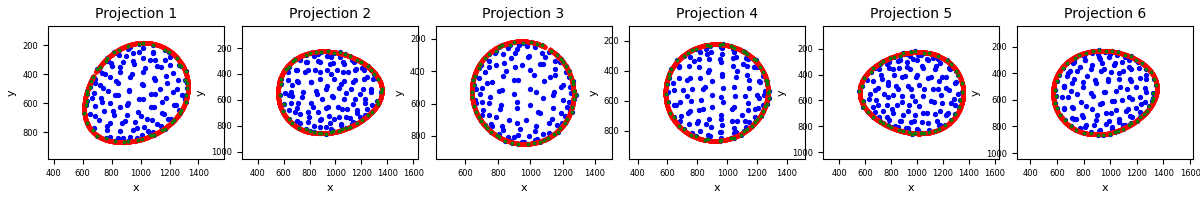

  40 Loss: 3269.2251586914062 Volume: 4.249397 SSE: 0.9345371889227252 Chamfer: 0.011537495069205761
  41 Loss: 3229.6246337890625 Volume: 4.249397 SSE: 0.9468778005062525 Chamfer: 0.011689849197864532
  42 Loss: 3193.9028930664062 Volume: 4.249397 SSE: 0.9587502417735886 Chamfer: 0.01183642353862524
  43 Loss: 3160.0335693359375 Volume: 4.249397 SSE: 0.9701973559866481 Chamfer: 0.011977745220065117
  44 Loss: 3128.0154418945312 Volume: 4.249397 SSE: 0.9812605414648501 Chamfer: 0.012114330194890499
  45 Loss: 3097.85400390625 Volume: 4.249397 SSE: 0.991968556636507 Chamfer: 0.012246524915099144
  46 Loss: 3069.4235229492188 Volume: 4.249397 SSE: 1.0023377216095801 Chamfer: 0.012374539859592915
  47 Loss: 3042.6358032226562 Volume: 4.249397 SSE: 1.0123966763097376 Chamfer: 0.012498723343014717
  48 Loss: 3017.3440551757812 Volume: 4.249397 SSE: 1.0221527370149361 Chamfer: 0.012619168497622013
  49 Loss: 2993.299560546875 Volume: 4.249397 SSE: 1.0316255490960133 Chamfer: 0.01273611746728

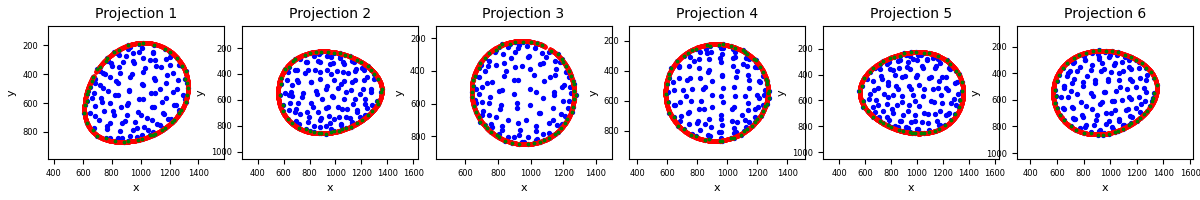

  50 Loss: 2970.3921508789062 Volume: 4.249397 SSE: 1.0408605402693911 Chamfer: 0.01285012997686863
  51 Loss: 2954.8287963867188 Volume: 4.249397 SSE: 1.0498593826751472 Chamfer: 0.01296122558414936
  52 Loss: 2928.6331176757812 Volume: 4.249397 SSE: 1.0586331289214 Chamfer: 0.013069543987512589
  53 Loss: 2908.717041015625 Volume: 4.249397 SSE: 1.0672167020860486 Chamfer: 0.013175513595342636
  54 Loss: 2889.6658325195312 Volume: 4.249397 SSE: 1.0756038915569817 Chamfer: 0.013279059901833534
  55 Loss: 2871.5347290039062 Volume: 4.249397 SSE: 1.0837847052496559 Chamfer: 0.013380058109760284
  56 Loss: 2854.2984008789062 Volume: 4.249397 SSE: 1.0917574658369333 Chamfer: 0.01347848679870367
  57 Loss: 2837.8018188476562 Volume: 4.249397 SSE: 1.0995366580705828 Chamfer: 0.013574526645243168
  58 Loss: 2821.9293212890625 Volume: 4.249397 SSE: 1.1071413393115963 Chamfer: 0.01366841234266758
  59 Loss: 2806.7404174804688 Volume: 4.249397 SSE: 1.1145676436846361 Chamfer: 0.01376009453088045

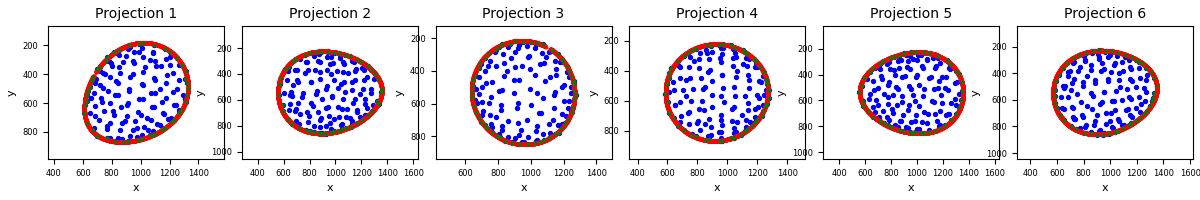

  60 Loss: 2792.1719360351562 Volume: 4.249397 SSE: 1.1218142562702558 Chamfer: 0.013849560171365738
  61 Loss: 2778.2168579101562 Volume: 4.249397 SSE: 1.1288922596495337 Chamfer: 0.01393694058060646
  62 Loss: 2764.932861328125 Volume: 4.249397 SSE: 1.1357945296098682 Chamfer: 0.014022152870893478
  63 Loss: 2749.6170043945312 Volume: 4.249397 SSE: 1.1425147180353619 Chamfer: 0.014105119742453098
  64 Loss: 2737.1975708007812 Volume: 4.249397 SSE: 1.149111221965856 Chamfer: 0.014186559244990349
  65 Loss: 2725.11474609375 Volume: 4.249397 SSE: 1.1555975117309867 Chamfer: 0.014266635291278362
  66 Loss: 2713.4463500976562 Volume: 4.249397 SSE: 1.1619683657690532 Chamfer: 0.014345290139317513
  67 Loss: 2702.2225952148438 Volume: 4.249397 SSE: 1.1682146291298892 Chamfer: 0.014422401785850525
  68 Loss: 2691.4572143554688 Volume: 4.249397 SSE: 1.1743221703734266 Chamfer: 0.014497804455459118
  69 Loss: 2681.1331176757812 Volume: 4.249397 SSE: 1.1803006076489952 Chamfer: 0.01457161270081

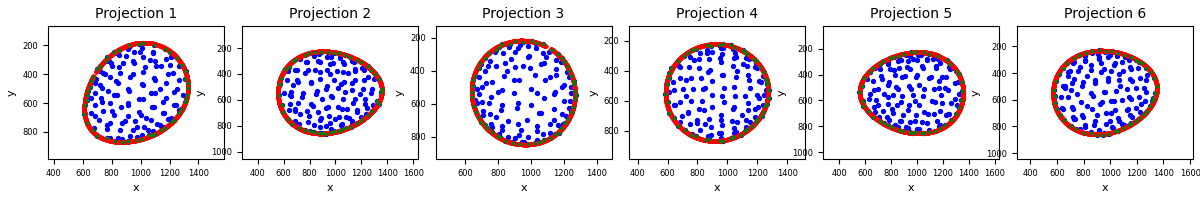

  70 Loss: 2671.2393188476562 Volume: 4.249397 SSE: 1.1861350725592652 Chamfer: 0.014643643982708454
  71 Loss: 2661.7880249023438 Volume: 4.249397 SSE: 1.191829619297758 Chamfer: 0.014713944867253304
  72 Loss: 2652.6840209960938 Volume: 4.249397 SSE: 1.1973914462396016 Chamfer: 0.014782611280679703
  73 Loss: 2643.7835693359375 Volume: 4.249397 SSE: 1.2028447952534724 Chamfer: 0.014849936589598656
  74 Loss: 2635.1431274414062 Volume: 4.249397 SSE: 1.2081973979371978 Chamfer: 0.014916018582880497
  75 Loss: 2626.79931640625 Volume: 4.249397 SSE: 1.213459019906303 Chamfer: 0.014980975538492203
  76 Loss: 2618.7753295898438 Volume: 4.249397 SSE: 1.2186160149233065 Chamfer: 0.015044640749692917
  77 Loss: 2611.0498046875 Volume: 4.249397 SSE: 1.2236609603925357 Chamfer: 0.015106924809515476
  78 Loss: 2603.5394287109375 Volume: 4.249397 SSE: 1.2286089640354334 Chamfer: 0.015168012119829655
  79 Loss: 2596.2789916992188 Volume: 4.249397 SSE: 1.233459991707879 Chamfer: 0.01522790174931287

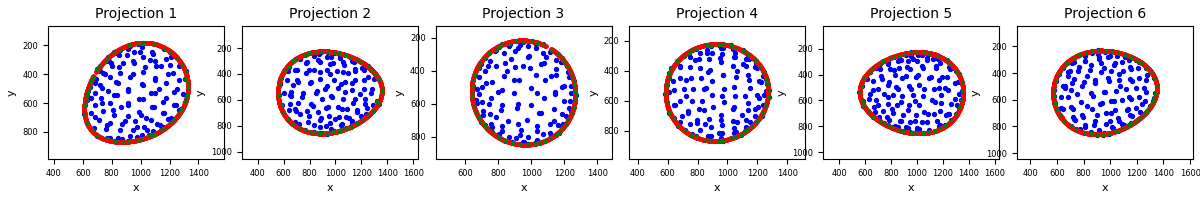

  80 Loss: 2589.2538452148438 Volume: 4.249397 SSE: 1.2382192873634046 Chamfer: 0.015286657959222794
  81 Loss: 2582.420654296875 Volume: 4.249397 SSE: 1.2428973887466013 Chamfer: 0.015344412066042423
  82 Loss: 2579.3133544921875 Volume: 4.249397 SSE: 1.2474893161866996 Chamfer: 0.015401102602481842
  83 Loss: 2572.2930908203125 Volume: 4.249397 SSE: 1.252066208022565 Chamfer: 0.015457606874406338
  84 Loss: 2565.2865600585938 Volume: 4.249397 SSE: 1.2566002829382799 Chamfer: 0.015513583086431026
  85 Loss: 2558.401641845703 Volume: 4.249397 SSE: 1.261083304658281 Chamfer: 0.0155689287930727
  86 Loss: 2551.6758728027344 Volume: 4.249397 SSE: 1.2655116169503522 Chamfer: 0.015623600222170353
  87 Loss: 2545.153350830078 Volume: 4.249397 SSE: 1.2698845185145387 Chamfer: 0.015677588060498238
  88 Loss: 2538.8526916503906 Volume: 4.249397 SSE: 1.2741831884747532 Chamfer: 0.015730656683444977
  89 Loss: 2532.8004455566406 Volume: 4.249397 SSE: 1.27840771888135 Chamfer: 0.015782812610268593

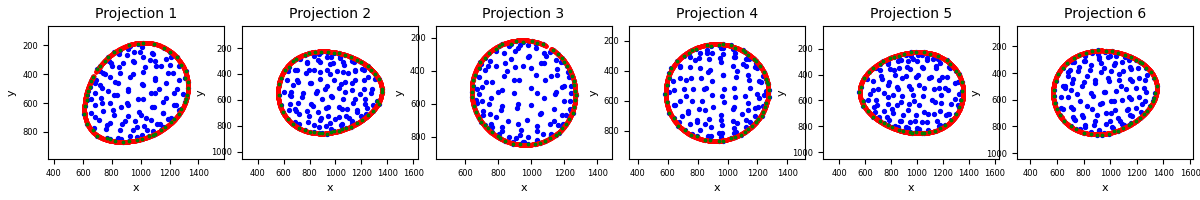

  90 Loss: 2526.956329345703 Volume: 4.249397 SSE: 1.282554748435146 Chamfer: 0.015834011137485504
  91 Loss: 2521.314239501953 Volume: 4.249397 SSE: 1.286623149625876 Chamfer: 0.015884235501289368
  92 Loss: 2515.828857421875 Volume: 4.249397 SSE: 1.2906239480908213 Chamfer: 0.015933627262711525
  93 Loss: 2510.489501953125 Volume: 4.249397 SSE: 1.2945620344599138 Chamfer: 0.0159822478890419
  94 Loss: 2505.3196716308594 Volume: 4.249397 SSE: 1.2984297076440587 Chamfer: 0.016029996797442436
  95 Loss: 2500.2439880371094 Volume: 4.249397 SSE: 1.3022472506473557 Chamfer: 0.016077129170298576
  96 Loss: 2495.299530029297 Volume: 4.249397 SSE: 1.3060015491717731 Chamfer: 0.01612347550690174
  97 Loss: 2490.5137634277344 Volume: 4.249397 SSE: 1.309686946434901 Chamfer: 0.016168974339962006
  98 Loss: 2485.8746337890625 Volume: 4.249397 SSE: 1.3133085006353187 Chamfer: 0.016213687136769295
  99 Loss: 2481.3299560546875 Volume: 4.249397 SSE: 1.3168822563118252 Chamfer: 0.01625780574977398


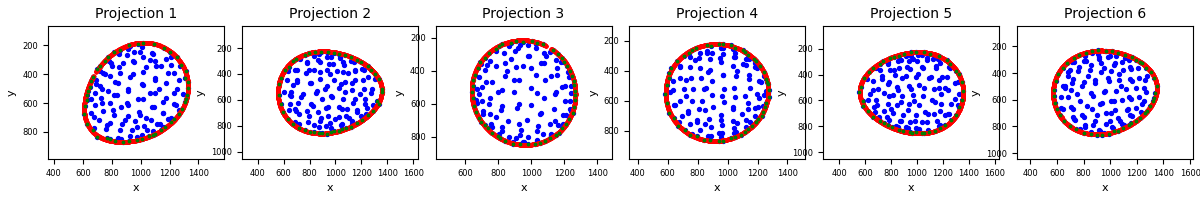

 100 Loss: 2476.9012451171875 Volume: 4.249397 SSE: 1.32041228331323 Chamfer: 0.016301386058330536
 101 Loss: 2472.593231201172 Volume: 4.249397 SSE: 1.323882238583673 Chamfer: 0.0163442250341177
 102 Loss: 2468.3489990234375 Volume: 4.249397 SSE: 1.3273110375303288 Chamfer: 0.01638655550777912
 103 Loss: 2464.185028076172 Volume: 4.249397 SSE: 1.330708882571564 Chamfer: 0.0164285060018301
 104 Loss: 2460.122833251953 Volume: 4.249397 SSE: 1.3340589390042237 Chamfer: 0.016469862312078476
 105 Loss: 2456.11572265625 Volume: 4.249397 SSE: 1.3373730204463032 Chamfer: 0.016510777175426483
 106 Loss: 2452.1551513671875 Volume: 4.249397 SSE: 1.3406562464439264 Chamfer: 0.016551310196518898
 107 Loss: 2448.3238220214844 Volume: 4.249397 SSE: 1.343889504420169 Chamfer: 0.016591228544712067
 108 Loss: 2444.599151611328 Volume: 4.249397 SSE: 1.3470667568891976 Chamfer: 0.01663045585155487
 109 Loss: 2440.9217834472656 Volume: 4.249397 SSE: 1.3502191557916308 Chamfer: 0.016669373959302902


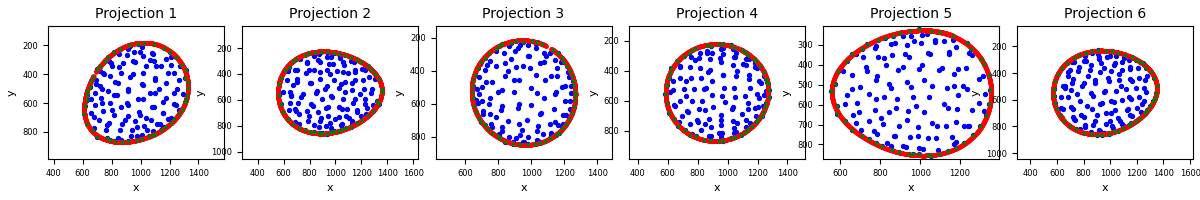

 110 Loss: 2750.7009887695312 Volume: 4.249397 SSE: 1.3533264356690256 Chamfer: 0.016707735136151314
 111 Loss: 2433.8525390625 Volume: 4.249397 SSE: 1.3569765291279219 Chamfer: 0.01675279624760151
 112 Loss: 2430.4795837402344 Volume: 4.249397 SSE: 1.3602682976459217 Chamfer: 0.01679343357682228
 113 Loss: 2427.194061279297 Volume: 4.249397 SSE: 1.3633487438145695 Chamfer: 0.016831466928124428
 114 Loss: 2423.928985595703 Volume: 4.249397 SSE: 1.3663080192231383 Chamfer: 0.016868000850081444
 115 Loss: 2420.680389404297 Volume: 4.249397 SSE: 1.3692014026695176 Chamfer: 0.016903722658753395
 116 Loss: 2417.486114501953 Volume: 4.249397 SSE: 1.3720491064075444 Chamfer: 0.01693887636065483
 117 Loss: 2414.338836669922 Volume: 4.249397 SSE: 1.374855567242204 Chamfer: 0.016973527148365974
 118 Loss: 2411.269989013672 Volume: 4.249397 SSE: 1.3776190944544604 Chamfer: 0.01700764149427414
 119 Loss: 2408.2765197753906 Volume: 4.249397 SSE: 1.3803353597627666 Chamfer: 0.017041178420186043


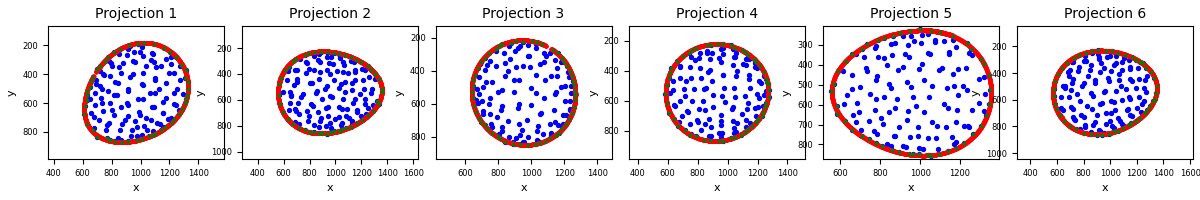

 120 Loss: 2405.3428649902344 Volume: 4.249397 SSE: 1.3830243430101525 Chamfer: 0.017074376344680786
 121 Loss: 2402.439727783203 Volume: 4.249397 SSE: 1.3856913624593377 Chamfer: 0.017107300460338593
 122 Loss: 2399.59716796875 Volume: 4.249397 SSE: 1.3883237307959109 Chamfer: 0.017139799892902374
 123 Loss: 2396.81640625 Volume: 4.249397 SSE: 1.3909140124141757 Chamfer: 0.01717177778482437
 124 Loss: 2394.0924072265625 Volume: 4.249397 SSE: 1.3934736709408928 Chamfer: 0.017203377559781075
 125 Loss: 2391.427764892578 Volume: 4.249397 SSE: 1.3960020831814832 Chamfer: 0.017234593629837036
 126 Loss: 2388.8160705566406 Volume: 4.249397 SSE: 1.3984925842779645 Chamfer: 0.017265338450670242
 127 Loss: 2386.261444091797 Volume: 4.249397 SSE: 1.400947139538321 Chamfer: 0.01729564368724823
 128 Loss: 2383.7669372558594 Volume: 4.249397 SSE: 1.4033660347291517 Chamfer: 0.01732550375163555
 129 Loss: 2381.3136291503906 Volume: 4.249397 SSE: 1.4057556829594904 Chamfer: 0.01735500805079937


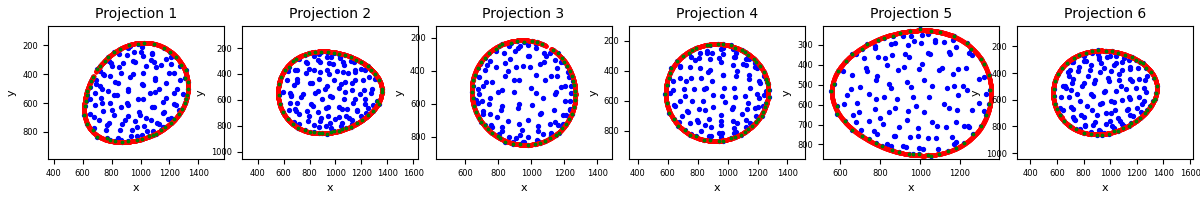

 130 Loss: 2983.5177612304688 Volume: 4.249397 SSE: 1.4081116705758672 Chamfer: 0.01738409511744976
 131 Loss: 2376.9964599609375 Volume: 4.249397 SSE: 1.4103797836066485 Chamfer: 0.01741209626197815
 132 Loss: 2374.90478515625 Volume: 4.249397 SSE: 1.4126444371298559 Chamfer: 0.017440056428313255
 133 Loss: 2372.7549743652344 Volume: 4.249397 SSE: 1.4148822393676967 Chamfer: 0.0174676813185215
 134 Loss: 2370.578155517578 Volume: 4.249397 SSE: 1.4170925363191975 Chamfer: 0.017494969069957733
 135 Loss: 2368.4234619140625 Volume: 4.249397 SSE: 1.4192715565569534 Chamfer: 0.017521869391202927
 136 Loss: 2366.293487548828 Volume: 4.249397 SSE: 1.4214227735850637 Chamfer: 0.01754843071103096
 137 Loss: 2364.1978454589844 Volume: 4.249397 SSE: 1.4235422083976899 Chamfer: 0.017574595287442207
 138 Loss: 2362.1327209472656 Volume: 4.249397 SSE: 1.4256441267608169 Chamfer: 0.017600545659661293
 139 Loss: 2360.081024169922 Volume: 4.249397 SSE: 1.4277302291209992 Chamfer: 0.01762629859149456


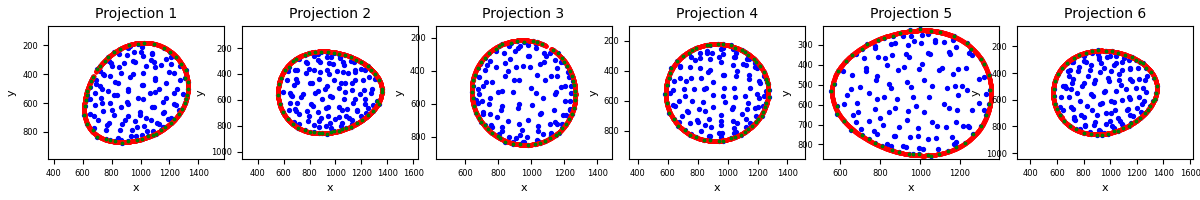

 140 Loss: 2358.065643310547 Volume: 4.249397 SSE: 1.4297916731408562 Chamfer: 0.0176517516374588
 141 Loss: 2356.068878173828 Volume: 4.249397 SSE: 1.431834121670358 Chamfer: 0.01767696626484394
 142 Loss: 2354.086151123047 Volume: 4.249397 SSE: 1.4338734148450807 Chamfer: 0.017702141776680946
 143 Loss: 2352.141571044922 Volume: 4.249397 SSE: 1.4359065231574202 Chamfer: 0.017727240920066833
 144 Loss: 2350.220489501953 Volume: 4.249397 SSE: 1.437917415280014 Chamfer: 0.017752068117260933
 145 Loss: 2348.3055114746094 Volume: 4.249397 SSE: 1.4399142024838216 Chamfer: 0.017776716500520706
 146 Loss: 2346.374969482422 Volume: 4.249397 SSE: 1.441904088591516 Chamfer: 0.01780128851532936
 147 Loss: 2344.452667236328 Volume: 4.249397 SSE: 1.4438980970182778 Chamfer: 0.0178259015083313
 148 Loss: 2342.548828125 Volume: 4.249397 SSE: 1.4458816344576084 Chamfer: 0.017850391566753387
 149 Loss: 2340.6756591796875 Volume: 4.249397 SSE: 1.4478530879946383 Chamfer: 0.01787472888827324


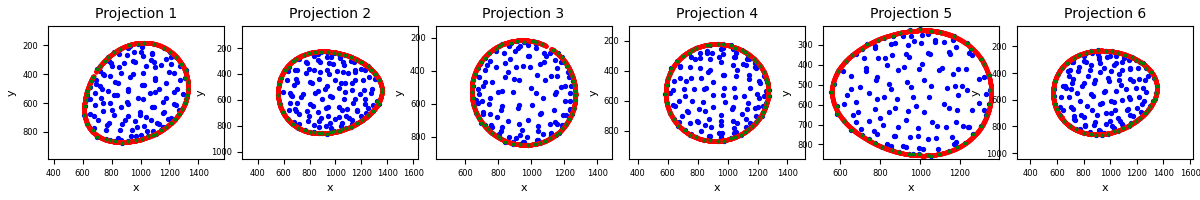

 150 Loss: 2338.843536376953 Volume: 4.249397 SSE: 1.4498083304090787 Chamfer: 0.017898866906762123
 151 Loss: 2337.0375061035156 Volume: 4.249397 SSE: 1.4517439351093242 Chamfer: 0.017922764644026756
 152 Loss: 2335.2593994140625 Volume: 4.249397 SSE: 1.45366180823997 Chamfer: 0.01794644258916378
 153 Loss: 2333.5093688964844 Volume: 4.249397 SSE: 1.4555622135862578 Chamfer: 0.017969906330108643
 154 Loss: 2331.7796325683594 Volume: 4.249397 SSE: 1.4574512789431795 Chamfer: 0.017993226647377014
 155 Loss: 2330.0596618652344 Volume: 4.249397 SSE: 1.4593394702395759 Chamfer: 0.01801653765141964
 156 Loss: 2328.3775329589844 Volume: 4.249397 SSE: 1.4612113112908838 Chamfer: 0.01803964376449585
 157 Loss: 2326.7340087890625 Volume: 4.249397 SSE: 1.4630602408757392 Chamfer: 0.018062474206089973
 158 Loss: 2936.7556762695312 Volume: 4.249397 SSE: 1.4648979805759734 Chamfer: 0.018085159361362457
 159 Loss: 2787.3233032226562 Volume: 4.249397 SSE: 1.4666544841519855 Chamfer: 0.018106842413544

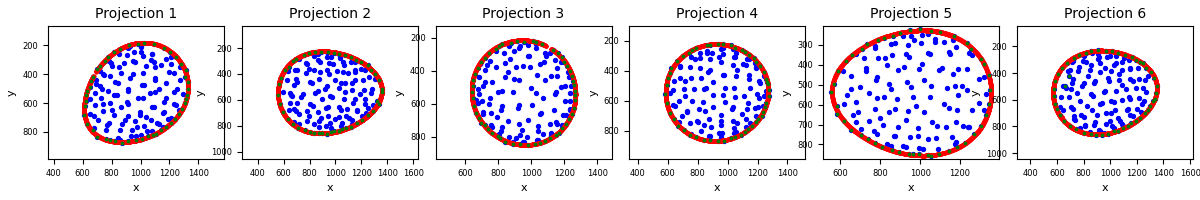

 160 Loss: 2776.2698364257812 Volume: 4.249397 SSE: 1.4680177021450194 Chamfer: 0.018123673275113106
 161 Loss: 2763.6996459960938 Volume: 4.249397 SSE: 1.4692048907561008 Chamfer: 0.018138330429792404
 162 Loss: 2750.5740356445312 Volume: 4.249397 SSE: 1.47032982035555 Chamfer: 0.01815222017467022
 163 Loss: 2737.3715209960938 Volume: 4.249397 SSE: 1.4714569529715045 Chamfer: 0.018166134133934975
 164 Loss: 2724.3209838867188 Volume: 4.249397 SSE: 1.4726147462602162 Chamfer: 0.018180429935455322
 165 Loss: 2711.5261840820312 Volume: 4.249397 SSE: 1.4738215381713895 Chamfer: 0.01819532923400402
 166 Loss: 2699.033203125 Volume: 4.249397 SSE: 1.475085668799587 Chamfer: 0.018210934475064278
 167 Loss: 2317.584228515625 Volume: 4.249397 SSE: 1.4764068867528644 Chamfer: 0.01822724938392639
 168 Loss: 2316.46240234375 Volume: 4.249397 SSE: 1.4779698205630707 Chamfer: 0.018246542662382126
 169 Loss: 2315.185546875 Volume: 4.249397 SSE: 1.4796267118963438 Chamfer: 0.01826699636876583


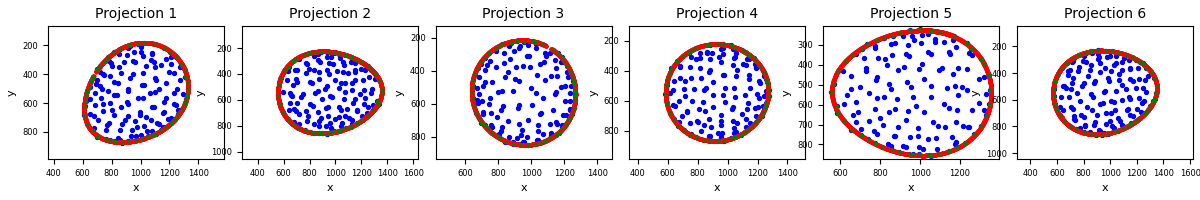

 170 Loss: 2313.8368225097656 Volume: 4.249397 SSE: 1.481318059804027 Chamfer: 0.01828787662088871
 171 Loss: 2312.464141845703 Volume: 4.249397 SSE: 1.483012891239814 Chamfer: 0.018308797851204872
 172 Loss: 2311.0646057128906 Volume: 4.249397 SSE: 1.4847145413690592 Chamfer: 0.018329808488488197
 173 Loss: 2309.662628173828 Volume: 4.249397 SSE: 1.4864158141401616 Chamfer: 0.018350811675190926
 174 Loss: 2670.4898071289062 Volume: 4.249397 SSE: 1.4881030961574633 Chamfer: 0.018371641635894775
 175 Loss: 2307.2190856933594 Volume: 4.249397 SSE: 1.4896033273834732 Chamfer: 0.018390163779258728
 176 Loss: 2305.998077392578 Volume: 4.249397 SSE: 1.4911924072524305 Chamfer: 0.01840978115797043
 177 Loss: 2304.6856689453125 Volume: 4.249397 SSE: 1.4928396964466515 Chamfer: 0.01843011938035488
 178 Loss: 2303.353729248047 Volume: 4.249397 SSE: 1.494499463017622 Chamfer: 0.01845061220228672
 179 Loss: 2656.4102172851562 Volume: 4.249397 SSE: 1.496156804845718 Chamfer: 0.018471073359251022


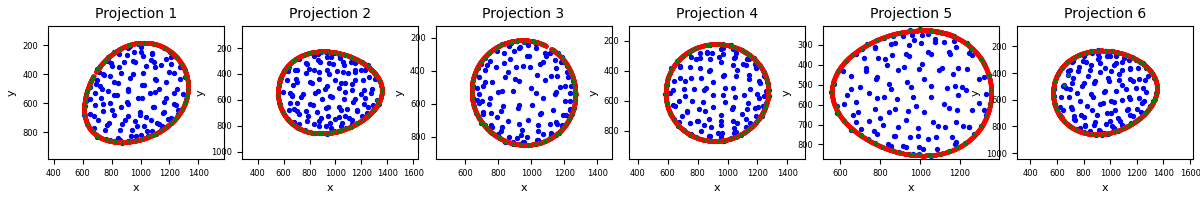

 180 Loss: 2300.995330810547 Volume: 4.249397 SSE: 1.4976426922592398 Chamfer: 0.0184894148260355
 181 Loss: 2299.849395751953 Volume: 4.249397 SSE: 1.4991956486901596 Chamfer: 0.018508587032556534
 182 Loss: 2298.6419677734375 Volume: 4.249397 SSE: 1.5007731753810525 Chamfer: 0.018528062850236893
 183 Loss: 2643.6199951171875 Volume: 4.249397 SSE: 1.50235537477712 Chamfer: 0.018547596409916878
 184 Loss: 2296.492919921875 Volume: 4.249397 SSE: 1.5037886903244897 Chamfer: 0.01856529340147972
 185 Loss: 2295.415496826172 Volume: 4.249397 SSE: 1.5052855779737802 Chamfer: 0.01858377456665039
 186 Loss: 2294.2657470703125 Volume: 4.249397 SSE: 1.5068170320196206 Chamfer: 0.018602678552269936
 187 Loss: 2630.9396362304688 Volume: 4.249397 SSE: 1.5083627070493357 Chamfer: 0.018621759489178658
 188 Loss: 2292.199249267578 Volume: 4.249397 SSE: 1.5097827894801856 Chamfer: 0.018639294430613518
 189 Loss: 2291.13525390625 Volume: 4.249397 SSE: 1.5112755323243388 Chamfer: 0.01865772344172001


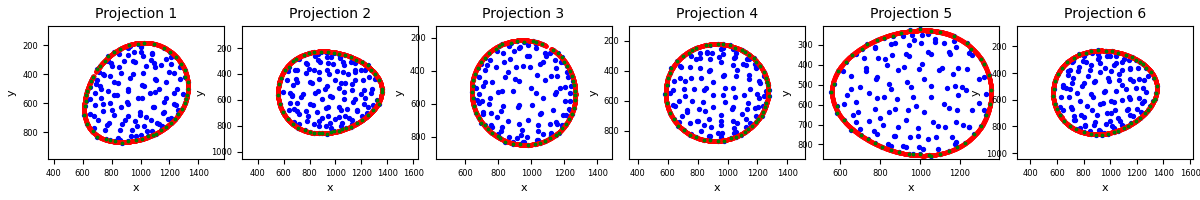

 190 Loss: 2289.9754333496094 Volume: 4.249397 SSE: 1.5127958913128736 Chamfer: 0.01867649331688881
 191 Loss: 2618.4451293945312 Volume: 4.249397 SSE: 1.5143338836388243 Chamfer: 0.01869547739624977
 192 Loss: 2287.8240966796875 Volume: 4.249397 SSE: 1.5157722206990738 Chamfer: 0.018713239580392838
 193 Loss: 2286.7333984375 Volume: 4.249397 SSE: 1.5172654490033928 Chamfer: 0.018731674179434776
 194 Loss: 2285.58349609375 Volume: 4.249397 SSE: 1.5187703378585469 Chamfer: 0.018750250339508057
 195 Loss: 2284.394989013672 Volume: 4.249397 SSE: 1.5202818373248035 Chamfer: 0.018768910318613052
 196 Loss: 2848.2174682617188 Volume: 4.249397 SSE: 1.521783476705435 Chamfer: 0.018787451088428497
 197 Loss: 2837.7072143554688 Volume: 4.249397 SSE: 1.5238186806078855 Chamfer: 0.018812576308846474
 198 Loss: 2823.08349609375 Volume: 4.249397 SSE: 1.5261425410579466 Chamfer: 0.01884126290678978
 199 Loss: 2807.0199584960938 Volume: 4.249397 SSE: 1.5286310187312337 Chamfer: 0.018871989101171494


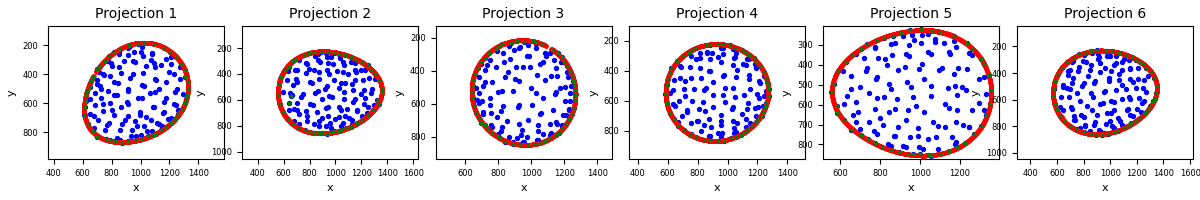

In [114]:
final_verts, history = outer_problem(sphere, parabola, projmats, batch_tgt_edgemap_info, n_iters=200, lr=1e-6,moment=0.5)

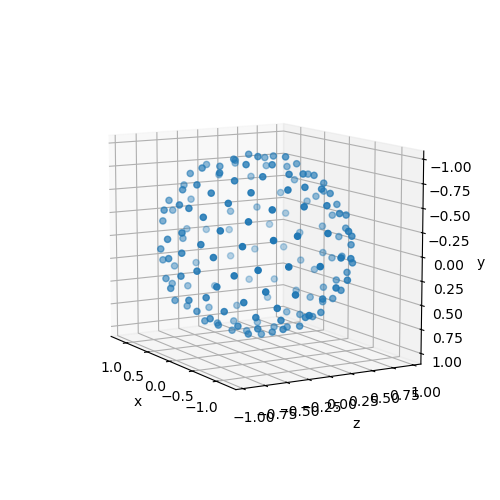

In [115]:
plot_vertices(final_verts)

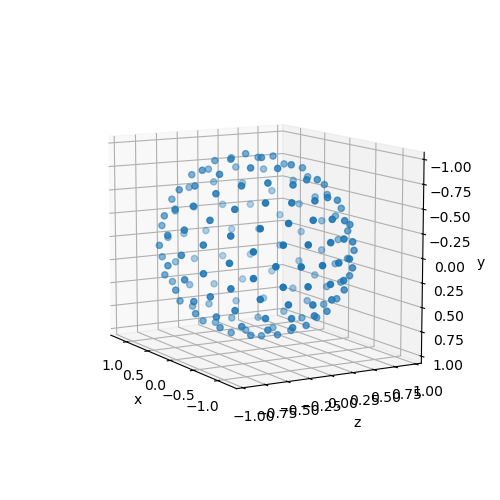

In [117]:
plot_vertices(balloon.verts_packed())